In [1]:
import pandas as pd
import numpy as np
import os
import re
from string import punctuation

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cosine
import ast

import ast
import fasttext
import itertools
import math
import pickle

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict, Counter
from operator import itemgetter
from heapq import nlargest, nsmallest
from scipy.spatial import distance
import random
from sklearn.metrics import silhouette_score
from itertools import combinations
from collections import Counter
import json

In [2]:
from tqdm import tqdm
tqdm.pandas()

In [3]:
df = pd.read_csv('./Datasets/2021-06-01 df_merged.csv')

In [21]:
df.country.value_counts()

IDN    51
COG    51
SYR    51
JPN    51
IND    51
       ..
DDR    18
TLS    18
SRB    15
MNE    15
SSD     9
Name: country, Length: 198, dtype: int64

In [4]:
df[df.country=='MKD'].loc[8168]['text']

"At the outset, I would like to congratulate\nMr. Holkeri on his election as President of the General\nAssembly at its fifty-fifth session. At the same time, I\nwould like to express our appreciation to the President\nof the General Assembly at its fifty-fourth session,\nMr. Theo-Ben Gurirab, for the results achieved during\nhis presidency.\nOn this occasion, I would also like to express our\ngratitude to Secretary-General Kofi Annan for his\nefficient and relevant leadership of the Organization.\nThe Republic of Macedonia will continue actively to\ncontribute to the realization of the goals of the United\nNations.\nI also welcome the admission of Tuvalu to the\nUnited Nations, wishing it success in its contribution to\nUnited Nations activities and expressing our wish to\nestablish diplomatic relations. At the same time, the\nRepublic of Macedonia expresses its readiness and\ncalls for the acceleration of the process of establishing\ndiplomatic relations with all other States Members 

In [5]:
df[df.is_war==1].country.value_counts()[-15:]

CHL    1
MDG    1
ROU    1
GRD    1
MKD    1
PAN    1
ECU    1
AUS    1
TTO    1
LSO    1
TZA    1
MDA    1
YUG    1
PRY    1
JOR    1
Name: country, dtype: int64

In [6]:
conflict = pd.read_csv(r'C:\Users\Paulius\OneDrive\Oxford University\Courses\Trinity\Thesis\Raw Data UN\Conflict and UN Data\ucdp-prio-acd-201.csv')

In [7]:
conflict[['conflict_id', 'year', 'side_a', 'side_b', 'type_of_conflict', 'incompatibility']].sort_values('year')

,conflict_id,year,side_a,side_b,type_of_conflict,incompatibility
151,200,1946,Government of Bolivia,Popular Revolutionary Movement,3,2
273,214,1946,Government of France,Government of Thailand,2,1
268,213,1946,Government of Russia (Soviet Union),UPA,3,1
265,212,1946,Government of Russia (Soviet Union),BDPS,3,1
264,211,1946,Government of Russia (Soviet Union),"LNPA, LTS(p)A",3,1
...,...,...,...,...,...,...
100,13646,2019,Government of Kenya,Al-Shabaab,4,1
834,259,2019,Government of Iraq,IS,4,2
105,13648,2019,Government of Egypt,IS,3,1
2207,391,2019,Government of Egypt,Harakit Sawa'id Misr,3,2


In [8]:
cols = [x for x in df.columns if x != 'country_map']
df[1300:][cols].head(7)

,year,country,text,session,is_war,n_conflicts,total_deaths,incompatibility,intensity,type_of_conflict,conflict_before
1300,2016,IDN,I wish to congratulate Mr. Peter Thomson on hi...,71,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict
1301,2017,IDN,Allow me to begin by wishing a happy new year ...,72,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict
1302,2018,IDN,I join others in congratulating Her Excellency...,73,True,1,25.0,Territory,Conflict,Intrastate,Conflict before
1303,2019,IDN,I would like to congratulate Ambassador Tijjan...,74,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict
1304,2020,IDN,His Excellency President of the UN General Ass...,75,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict
1305,1970,IND,"40.\t Mr. President, I offer you our congratul...",25,True,1,0.0,Government,Conflict,Intrastate,Conflict before
1306,1971,IND,"38.\tMr. President, on behalf of the people of...",26,True,2,0.0,G&T (multiple conflicts),Conflict & War (multiple conflicts),Multiple conflicts,Conflict before


# Descriptive

## Text Cleaning

In [9]:
# Define function to clean text
def clean(text):
    text = re.sub("[^a-zA-Z']", " ", text)
    text = ' '.join([w.lower() for w in text.split()])
    return text.split()

In [10]:
# Define function to clean text
def clean_no_split(text):
    text = re.sub("[^a-zA-Z'.]", " ", text)
    text = ' '.join([w.lower() for w in text.split()])
    return text

In [11]:
df['clean_text'] = df.text.map(clean)
df['clean_text_no_split'] = df.text.map(clean_no_split)
df['no_tokens'] = df.clean_text.map(len)

<AxesSubplot:>

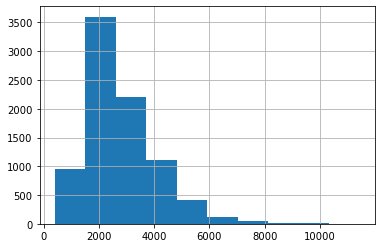

In [12]:
df['no_tokens'].hist()

## Yearly frequency metrics

In [13]:
yearly_agg = df.groupby('year').agg({
                        'no_tokens':'mean',
                        'text': 'count',
                        'is_war': 'sum',
                        'total_deaths': 'sum',
                        'n_conflicts': 'sum'})

In [14]:
# Read file that calculates all the countries that are in conflict
n_conflicts = pd.read_csv(r"C:\Users\Paulius\OneDrive\Oxford University\Courses\Trinity\Thesis\Data\Datasets\2021-06-02 country_n_conflicts.csv")
n_conflicts.columns = ['year', 'is_conflict_true']
n_conflicts = n_conflicts.set_index("year")

# Get number of countries that are actually in conflict
yearly_agg = pd.merge(yearly_agg, n_conflicts, left_index=True, right_index=True, how='left')
yearly_agg['n_wars_represented'] = yearly_agg['is_war'] / yearly_agg['is_conflict_true']

In [15]:
# Get UN Member states
UN_membs = pd.read_excel(r"C:\Users\Paulius\OneDrive\Oxford University\Courses\Trinity\Thesis\Data\Datasets\UN_member_states.xlsx")
UN_membs = UN_membs.set_index('year')

# Merge the file
yearly_agg = pd.merge(yearly_agg, UN_membs, left_index=True, right_index=True, how='left')

In [16]:
# Change column names
colnames = ['Speech word tokens (mean)', 'UNGD speeches', 'Speeches by countries in conflict', 'Total yearly deaths',
        'total conflicts', 'Total countries in conflict', '% conflicts represented', 'UN membership']

yearly_agg.columns = colnames

In [17]:
# Do other common transformations
yearly_agg = yearly_agg.replace(0.0, 'NaN')
yearly_agg['Speech word tokens (mean)'] = yearly_agg['Speech word tokens (mean)'].round(1)
yearly_agg['% conflicts represented'] = yearly_agg['% conflicts represented'].round(2)

# Drop 2020 year since it has mostly NAs
yearly_agg = yearly_agg.drop(2020)

# Convert to int
yearly_agg['Total countries in conflict'] = yearly_agg['Total countries in conflict'].astype(int)

In [18]:
# Extract required columns and export to latex
cols = ['UN membership', 'UNGD speeches', 'Speech word tokens (mean)', 'Speeches by countries in conflict', 'Total countries in conflict']
yearly_agg_export = yearly_agg[cols]

In [19]:
yearly_agg_export.to_csv("./Datasets/2021-07-25 agg_data.csv")

In [14]:
yearly_agg_export.head()

,UN membership,UNGD speeches,Speech word tokens (mean),Speeches by countries in conflict,Total countries in conflict
year,,,,,
1970,127,70,3919.2,10,22
1971,132,116,3958.7,18,24
1972,132,125,3921.6,18,23
1973,135,120,4042.8,15,21
1974,138,129,3990.9,19,25


In [15]:
yearly_agg_export.head()

,UN membership,UNGD speeches,Speech word tokens (mean),Speeches by countries in conflict,Total countries in conflict
year,,,,,
1970,127,70,3919.2,10,22
1971,132,116,3958.7,18,24
1972,132,125,3921.6,18,23
1973,135,120,4042.8,15,21
1974,138,129,3990.9,19,25


In [16]:
yearly_agg_export.head()

,UN membership,UNGD speeches,Speech word tokens (mean),Speeches by countries in conflict,Total countries in conflict
year,,,,,
1970,127,70,3919.2,10,22
1971,132,116,3958.7,18,24
1972,132,125,3921.6,18,23
1973,135,120,4042.8,15,21
1974,138,129,3990.9,19,25


In [37]:
def change_axis_size(ax, ax2, fontsize):
    """Changes the size of the axis to the fontsize specificed"""
    for tick in ax.xaxis.get_major_ticks(): tick.label.set_fontsize(fontsize) 
    for tick in ax.yaxis.get_major_ticks(): tick.label.set_fontsize(fontsize)
    for tick in ax2.yaxis.get_major_ticks(): tick.label2.set_fontsize(fontsize)

In [63]:
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']

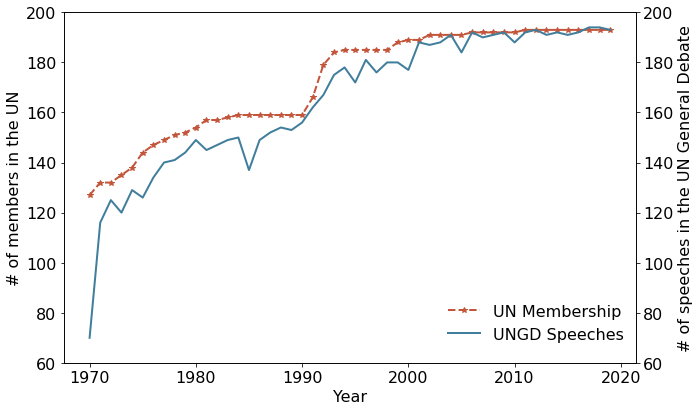

In [126]:
# Set size parameters 
plt.rcParams.update({'font.size': 16})

# Set figure size 
fig, ax = plt.subplots(1,1, figsize=(10,6), sharey=True)

# Get second axis
ax2 = ax.twinx()

# Get plot features
ax.plot(yearly_agg_export['UN membership'], color=colorcodes[0], label='UN Membership', linestyle='--', marker='*', linewidth=2)
ax2.plot(yearly_agg_export['UNGD speeches'], color=colorcodes[-1], label= 'UNGD Speeches', linewidth=2)

# Set axes
ax.set_ylim((60,200))
ax.set_ylabel("# of members in the UN")
ax2.set_ylim((60, 200))
ax2.set_ylabel("# of speeches in the UN General Debate")


# Set x axis parameters
ax.set_xlabel("Year")

# Set legend
leg = fig.legend(loc='lower right', bbox_to_anchor=(0.9,0.15))
leg.get_frame().set_linewidth(0.0)

plt.tight_layout()
fig.savefig('./Figures/2021-06-30 membership_speeches.pdf')

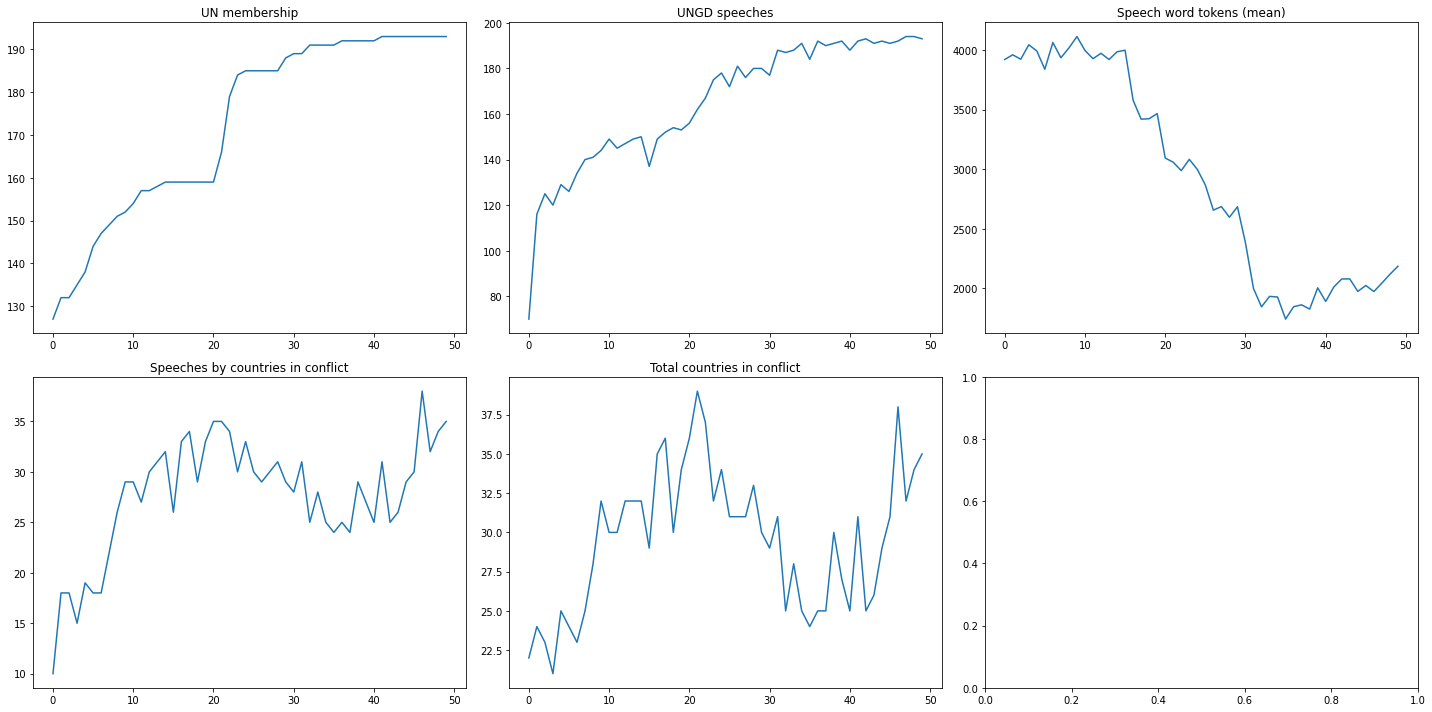

In [17]:
fig, axs = plt.subplots(2,3, figsize=(20, 10))

axs_list = axs.flatten()
for i, ax in enumerate(axs_list):
    if i == 5: break
    ax.plot(yearly_agg_export.iloc[:,i].values)
    ax.set_title(yearly_agg_export.columns[i])
plt.tight_layout()

In [178]:
# Extract required columns and export to latex
cols = ['UN membership', 'UNGD speeches', 'Speech word tokens (mean)', 'Speeches by countries in conflict', 'Total countries in conflict']
yearly_agg_export = yearly_agg[cols]
yearly_agg_export.to_latex('summary_stats.tex')

## Answering descriptive questions

### Do countries in conflict speak more?

In [185]:
speechNoconf = df[df.is_war==False].groupby('year').no_tokens.mean()
speechConf = df[df.is_war==True].groupby('year').no_tokens.mean()

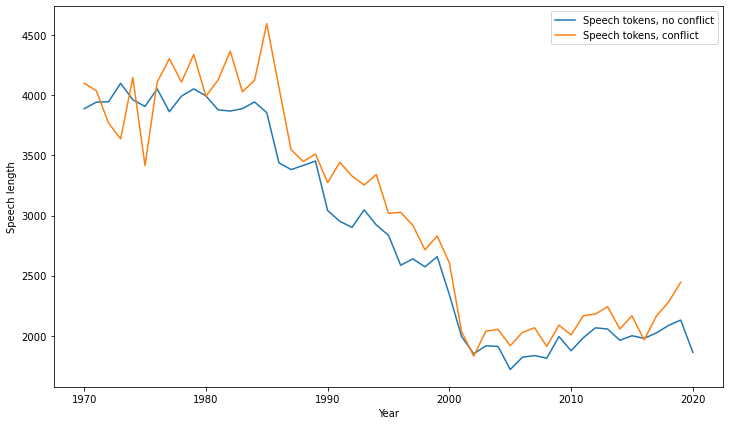

In [197]:
fig, ax = plt.subplots(1,1, figsize=(12,7))

ax.plot(speechNoconf, label='Speech tokens, no conflict')
ax.plot(speechConf, label = 'Speech tokens, conflict')

#ax.set_title("Difference in speech length by conflict")
ax.set_xlabel("Year")
ax.set_ylabel("Speech length")
ax.legend()

fig.savefig('./Figures/Speech_length.pdf')

## Country speeches by conflict type, intensity, etc.

In [199]:
df['type_of_conflict'].value_counts()

No conflict                     7064
Intrastate                       968
Internationalized intrastate     238
Multiple conflicts               104
Interstate                        74
Name: type_of_conflict, dtype: int64

In [201]:
df['intensity'].value_counts()

No conflict                            7064
Conflict                                968
War                                     289
Conflict & War (multiple conflicts)     127
Name: intensity, dtype: int64

In [207]:
df['no_tokens'].sum()/100_000

234.05175

## Constructing TF-IDF of words

### Cleaning the data

In [200]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [433]:
df['sentences'] = df.text.map(text2sent)

- Construct TF-IDF framework for each document
- Use the TF-IDF scores within each document as the weight
- Average the weight of each sentence of individual words of TF-IDF

tf_{i,j} * log(total_words/number of times i is mentioned)

In [20]:
d_frequency = pd.Series(df.clean_text).explode().value_counts()
id_frequency = np.log(d_frequency.sum()/d_frequency) # log(total_words/number of times d is mentioned)


In [18]:
def tfidf(s, id_frequency):
    
    # Log term frequency
    tf = np.log(pd.Series(s).value_counts())
    
    # TF-IDF score
    r = dict((tf * id_frequency[tf.index]).sort_values(ascending=False))
    
    return r

def calculate_tfidf(df):
    # Calculate document frequency for each word

    # Calculate IDF
    
    # Get tf-idf
    
    return df

In [ ]:
#df['word_weight'] = df['clean_text'].apply(tfidf, args=(id_frequency))

### Getting weights

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [167]:
stopwords = pd.read_csv('../Supplementary files/stopwords.txt', header=None)
stopwords = stopwords[0].tolist()

In [ ]:
def get_weights_sentences(sent, stopwords=stopwords):
    
    ## NOTE: bad version (used for sentences aggregation, not individual words)
    
    # Get all the words (assumes a 0 if word not found but that shouldnt happen)
    return [[sent['word_weight'].get(word.lower(), 0) if word not in stopwords else 0 for word in sentence.split()] for sentence in sent['clean_text']]

In [304]:
def get_weights(sent):
    
    return [sent['word_weight'][x] for x in sent['clean_text']]

In [271]:
def get_avg_weights_per_sentence(sent):
    
    # Get average scores for each sentence
    avgs = [np.mean(x) for x in sent]
    
    # Make so that they sum up to one
    return [x/np.sum(avgs) for x in avgs]

In [305]:
df['weights'] = df.progress_apply(get_weights, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 8448/8448 [08:12<00:00, 17.14it/s]


In [69]:
#df['avg_weight'] = df['weights'].progress_map(get_avg_weights_per_sentence)

In [310]:
df.to_csv('./Datasets/2021-06-11 main_df.csv', index=False)

# Analyzing topic modeling results

In [3]:
scores = pd.read_csv('./topic_model/2021-06-19 scores.csv', usecols = [1,2,3])

In [4]:
scores.index = (list(range(5,36)))

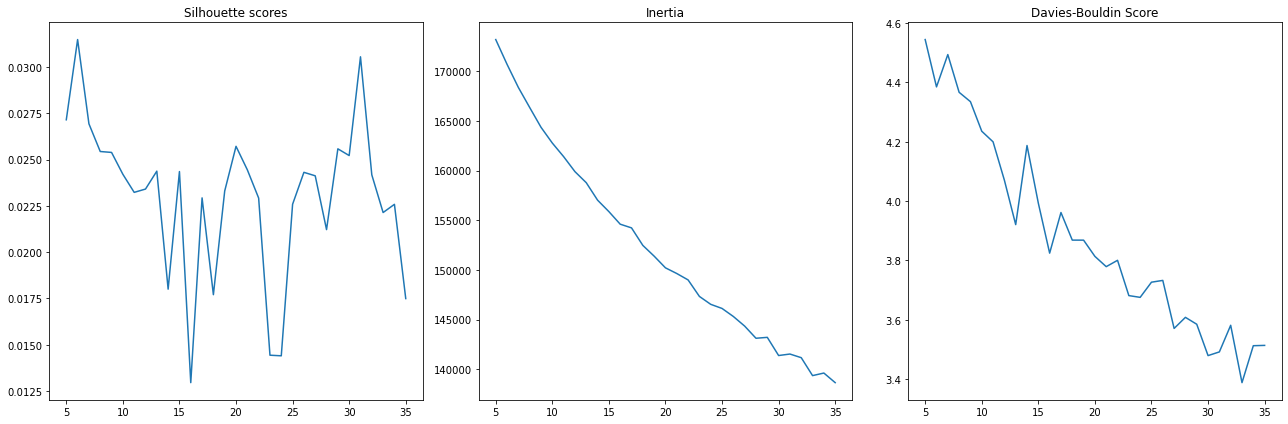

In [17]:
fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].plot(scores.silhouette_score);
axs[0].set_title("Silhouette scores")

axs[1].plot(scores.inertia)
axs[1].set_title("Inertia")

axs[2].plot(scores.dbs)
axs[2].set_title("Davies-Bouldin Score")

plt.tight_layout()
fig.savefig('./Figures/2021-07-04 clustering_scores.png')

In [16]:
import os
os.getcwd()

'C:\\Users\\Paulius\\OneDrive\\Oxford University\\Courses\\Trinity\\Thesis\\Data'

-> Choose k=26, but then I will not be evaluating all the clusters.
- I exclude some clusters since they are general
- I include some other ones since they are important theoretically

In [32]:
from sklearn.linear_model import LinearRegression
from numpy import exp

In [33]:
def softmax(vector):
	e = exp(vector)
	return e / e.sum()

In [43]:
y = np.array([10, 12, 15, 12, 5, 6, 2, 23])
x = np.array([8, 9, 12, 9, 4, 4, 1, 15])
x2 = softmax(x)
x3 = x**2

In [28]:
model = LinearRegression()
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
model.coef_

array([[1.41186441]])

In [35]:
model = LinearRegression()
model.fit(x2.reshape(-1, 1), y.reshape(-1, 1))
model.coef_

array([[15.40872586]])

In [41]:
model = LinearRegression()
model.fit(x3.reshape(-1, 1), y.reshape(-1, 1))
model.coef_

array([[10.94194915]])

In [46]:
import os
os.getcwd()

'C:\\Users\\Paulius\\OneDrive\\Oxford University\\Courses\\Trinity\\Thesis\\Data'

### Sampling 

$n = N / (1 + Ne^2)$

In [85]:
N = len(df)
e = 0.05
n = N / (1 + N * e**2)
print(f"The number of samples to evaluate is: {math.ceil(n)}")

The number of samples to evaluate is: 382


In [193]:
N = 9000
e = 0.01
n = N / (1 + N * e**2)
print(f"The number of samples to evaluate is: {math.ceil(n)}")

The number of samples to evaluate is: 4737


### Testing if embedding approaches are different

In [9]:
v1 = [0.2, 0.5]
v2 = [0.3, 0.232]
v3 = [0.5, 0.421]

topic = [0.1, 0.8]

In [15]:
cosines = []
for v in [v1, v2, v3]:
    cosines.append(1 - cosine(topic, v))

In [17]:
np.mean(cosines)

0.8021697664900361

In [22]:
1 - cosine(topic, np.mean([v1, v2, v3], axis=0))

0.8308857064253952

# Exporting files for embedding training

In [5]:
import nltk.data
from nltk import tokenize
from itertools import chain


In [6]:
# Define function to clean text
def clean(text):
    """Clean the textual data"""
    text = re.sub("[^a-zA-Z']", " ", text)
    text = ' '.join([w.lower() for w in text.split()])
    return text.split()

def to_sentence(s):
    """Convert a phrase to a sentence from an iterable s"""
    return list(chain.from_iterable(s))

In [7]:
from tqdm import tqdm
tqdm.pandas()

In [8]:
df = pd.read_csv('./Datasets/2021-07-08 dataset.csv')

In [9]:
df['text_clean'] = df['text'].progress_map(clean)

100%|█████████████████████████████████████████████████████████████████████████████| 8448/8448 [00:33<00:00, 249.50it/s]


In [10]:
# Sample a part of the dataframe
dft = df.sample(1000)
dft['sentences'] = dft['text'].progress_map(text2sent)

NameError: name 'text2sent' is not defined

In [32]:
dft['single_sentence'] = dft['sentences'].map(to_sentence)

## Getting common bigrams, trigrams, country names

In [11]:
from collections import defaultdict, Counter
from nltk.util import bigrams, trigrams


In [12]:
stopwords = pd.read_csv('../Supplementary files/stopwords.txt', header=None)
stopwords = stopwords[0].tolist()

In [ ]:
vocab_bi = defaultdict(Counter)

for speech in dft['single_sentence']:
    vocab_bi['speeches'].update(bigrams([w for w in speech if w not in stopwords]))

In [ ]:
vocab_tri = defaultdict(Counter)

for speech in dft['single_sentence']:
    vocab_tri['speeches'].update(trigrams([w for w in speech if w not in stopwords]))

In [ ]:
# Get top bigrams and trigrams in the whole corpus

words_general = ['general assembly', 'security council', 'climate change', 'united nations', 'weapons of mass destruction', 'human rights',
'developing countries', 'developed countries', 'global south', 'nuclear proliferation', 'nuclear weapons',
'world war', 'official development assistance', 'non proliferation', 'international court of justice',
'middle east', 'latin america', 'north america', 'sustainable development', 'self determination', 'soviet union',
'arms race', 'economic development', 'developing states', 'developed states', 'southern africa', 'european union', 'peace keeping', 'rule of law',
'cold war', 'economic growth', 'social development', 'chemical weapons', 'super power', 'world order',
'millennium development goals', 'millenium goals', 'soviet socialist republic']

# Get country names
import country_converter as coco
import pycountry_convert as pc

# Make a common list for all of them
cc = coco.CountryConverter()

In [ ]:
countrynames = pd.Series(df.country.unique()).map(lambda x: cc.convert(names=x, to='name_short'))


In [ ]:
# Get countrynames with more than one word
countrynames_bi = [x for x in countrynames.tolist() if len(x.split()) > 1]

# Additional states (different naming)
countrynames_bi + ['Great Britain', 'United Kingdom', 'federal republic of germany', 'Viet Nam', 'micronesia', 'north korea', 'south korea', 'democratic republic of congo', 'congo democratic republic']

# Lowercase and remove other items
countrynames_bi = [c.lower().replace("'", "").replace(".", "") for c in countrynames_bi]

# Multiple tokens - aggregated list
tokens_multiple = np.array(countrynames_bi + words_general)

In [83]:
# Export the multiple tokens
pd.Series(tokens_multiple).to_excel("2021-07-11 tokens_with_multiple_words.xlsx")

## Splitting sentences

In [13]:
tokens_multiple = pd.read_excel("2021-07-11 tokens_with_multiple_words.xlsx")[0].tolist()

In [17]:
def split_sentences(test_text, tokens_multiple=tokens_multiple):
    """Split the text so that the bigrams that appear are in the text"""
    
    # Get all the tokens in the text that are used
    tokens_used = tokens_multiple[np.array([x in test_text for x in tokens_multiple])]
    
    # Make a function to split by (if multiple terms, | splits by the "or" condition)
    split_by = '|'.join(tokens_used)
    
    # Get the text splitted
    test_text = re.split(f'({split_by})', test_text)

    # Get a list of sentences that are cleaned. Split by space unless the bigram exists in the text
    #[x] is used instead of x because [x] is a list and when reducing later it convers to a string
    list_of_sentences = [x.strip().split(' ') if x not in tokens_multiple else [x] for x in test_text]
    
    # Minimize from list of lists to list
    sentence_final = list(chain.from_iterable(list_of_sentences))

    # Return only words that have a length > 0
    return [x for x in sentence_final if len(x) > 0]


def split_multiple_sentences(sentences):
    """Given a list of sentences, see which ones need to be re-split into multiple tokens and 
    based on that re-modify them."""
    
    sentences_new = []
    for one_sentence in sentences:
        one_sentence_string = ' '.join(one_sentence)
        
        # Check if at least one word exists
        words_exist = False
        for word in tokens_multiple:
            if word in one_sentence_string:
                words_exist = True
        
        # If that word exists, employ the algorithm. Otherwise, ignore
        if words_exist: 
            sentences_new.append(split_sentences(one_sentence_string))
        else:
            sentences_new.append(one_sentence)
        
    return sentences_new

In [16]:
df['sentences_many_tokens'] = df.sentences.progress_map(split_multiple_sentences)

AttributeError: 'DataFrame' object has no attribute 'sentences'

In [ ]:
dft['sentences_many_tokens'] = dft.sentences.progress_map(split_multiple_sentences)

In [87]:
dft['sentences_many_tokens'].head()

3924    [[at, this, time, when, i, have, the, honour, ...
2574    [[ever, since, its, admission, to, the, great,...
2539    [[as, i, begin, my, statement, in, the, genera...
1065    [[mr, president, i, should, like, to, begin, b...
8192    [[i, would, like, to, express, my, sincere, co...
Name: sentences_many_tokens, dtype: object

In [519]:
def convert_to_ls(dft, filename = '2021-07-10 all_sentences.txt'):
    """Take the dataframe and convert their sentences (with many tokens) to a list.
    Later, export this list for embedding training."""
    print("Converting to lists...")
    # Get all the sentences in a list
    list_of_words = dft.sentences_many_tokens.tolist()
    
    # Remove the upper layer of the list (indication of speakers)
    list_of_words2 = list(chain.from_iterable(list_of_words))
    
    # Export
    print("Exporting...")
    
    with open(filename, 'w') as f:
        for line in list_of_words2:
            f.write(str(line))
            f.write('\n')

In [520]:
convert_to_ls(df)

Converting to lists...
Exporting...


In [1057]:
words_all = set(pd.Series(df.sentences_many_tokens).explode().explode().values)

In [504]:
# Get a list of words
list_of_words = dft.sentences_many_tokens.tolist()
list_of_words2 = list(chain.from_iterable(list_of_words))
list_of_words3 = list_of_words2[:1000]

# Export
with open('2021-07-10 all_sentences_sample.txt', 'w') as f:
    for line in list_of_words2:
        f.write(str(line))
        f.write('\n')

# Analysis - Topic model

MVP Pipeline: 

-> Filter only specific countries in Africa

-> Get the topics based on the clustering:
  - Clustering based on words
  - Clustering based on sentences:
   (a) Sentence BERT
   (b) TF-IDF weighting
  - Clustering based on paragraphs
   (a) Sentence BERT
   (b) TF-IDF weighting
  
-> Evaluate all the clustering of these topics
 - Clustering: silhouette score and other scores
 - Average intra-group cosine similarity

> Pick the best indicator

> Run a regression with the controls

> Run a regression with the indicators

> Run different lag versions


*Comment:* If I have this, I already have an MVP to test my hypothesis and showcase everything. All other things are just additional sensitivity analyses that are nice but not necessary to have. So, make sure I finish this. ASAP.

*Later additions:* Add lemmatization and stemming

## Creating a new benchmark dataset

- Get only Africa (done)
- Get dataset saved (done)
- Get tokens on word levels, but sentences (done)
- Get weights
- Build sentence-level embeddings (have pre-trained embeddings)
- Cluster (10 - 40)

In [3]:
from scipy.spatial.distance import cosine

In [4]:
# Uploading the vectors
vectors = pd.read_pickle('./embeddings/2021-07-10 wordvector.pickle')

In [19]:
# Drop useless columns (bad formatting)
dropcols = ['word_weight', 'weights', 'weights_avg', 'embedding_1', 'clean_text', 'clean_text_no_split', 'sentences']
df = df.drop(dropcols, axis=1)
df.to_csv('./Datasets/2021-07-08 dataset.csv', index=False)

In [24]:
mapping = pd.read_excel('./Datasets/UN_dataset.xlsx')
mapping = {k:v for k,v in zip(mapping.abbr, mapping.full_name)}

## Getting full country names

In [205]:
# Get countries and their short names
c = pd.Series(df.country.unique())
c_full = c.map(lambda x: cc.convert(names=x, to='name_short'))

# Get full countrynames
countrynames_df = pd.DataFrame([c, c_full]).transpose()
countrynames_df.columns = ['abbr', 'fullname']

YUG not found in ISO3
CSK not found in ISO3
YDYE not found in regex
DDR not found in ISO3


In [206]:
def country2continent(name):
    """Takes a country and returns the continent"""
    country_code = pc.country_name_to_country_alpha2(name, cn_name_format="default")
    continent_name = pc.country_alpha2_to_continent_code(country_code)
    return continent_name


In [256]:
dicts = {'Congo Republic': 'AF',
         "Cote d'Ivoire": 'AF',
        'DR Congo': 'AF',
        'YUG': 'EU',
       'CSK': 'EU',
       'YDYE': 'AS',
       'DDR': 'EU',
       'Vatican': 'SA',
       'Micronesia, Fed. Sts.': 'OC',
       'Timor-Leste': 'AS'}

In [265]:
continents = []
for c in countrynames_df.fullname.tolist():
    try:
        continent = country2continent(c)
        continents.append(continent)
    except:
        continents.append(dicts.get(c, 'other'))

In [258]:
# Print out all the values that have NAN
for x, y in zip(countrynames_df.fullname.tolist(), continents):
    if type(y) == float:
        print(x, y)

In [259]:
countrynames_df['continent'] = continents

In [261]:
abbr2name = {k:v for k,v in zip(countrynames_df.abbr, countrynames_df.fullname)}
abbr2cont = {k:v for k,v in zip(countrynames_df.abbr, countrynames_df.continent)}

In [262]:
# Filter only Africa
df['countryname'] = df.country.map(abbr2name)
df['continent'] = df.country.map(abbr2cont)

In [91]:
dfa = df[df.continent == 'AF'].copy()

In [266]:
df.to_csv('./Datasets/2021-07-14 dataset_all.csv', index=False)

In [263]:
df[df.continent == 'other'].country.unique()

array(['YUG', 'CSK', 'YDYE', 'DDR', 'VCT'], dtype=object)

In [264]:
df.continent.value_counts()

AF       2426
AS       2053
EU       1752
NA       1010
SA        618
OC        464
other     125
Name: continent, dtype: int64

In [93]:
dfa.to_csv('./Datasets/2021-07-08 dataset_Africa.csv', index=False)

## TF-IDF sentence weighting - Topic model

### Get sentences

In [3]:
import nltk
import collections
from itertools import chain
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import math

In [4]:
dfa = pd.read_csv('./Datasets/2021-07-08 dataset_Africa.csv')

In [5]:
tokens_multiple = np.array(pd.read_excel("./Datasets/2021-07-11 tokens_with_multiple_words.xlsx")[0].tolist())

In [6]:
def text2sent(t):
    """Convert a sentence to text"""
    
    # Split into sentences
    t = nltk.sent_tokenize(t)
    
    # Lowercase each sentence and remove sentences that have only 2 word or less after cleaning
    t = [clean(x) for x in t if len(clean(x)) > 2]
    
    return t

# Define function to clean text
def clean(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = ' '.join([w.lower() for w in text.split()])
    return text.split()

def split_sentences(test_text, tokens_multiple=tokens_multiple):
    """Split the text so that the bigrams that appear are in the text"""
    
    # Get all the tokens in the text that are used
    tokens_used = tokens_multiple[np.array([x in test_text for x in tokens_multiple])]
    
    # Make a function to split by (if multiple terms, | splits by the "or" condition)
    split_by = '|'.join(tokens_used)
    
    # Get the text splitted
    test_text = re.split(f'({split_by})', test_text)

    # Get a list of sentences that are cleaned. Split by space unless the bigram exists in the text
    #[x] is used instead of x because [x] is a list and when reducing later it convers to a string
    list_of_sentences = [x.strip().split(' ') if x not in tokens_multiple else [x] for x in test_text]
    
    # Minimize from list of lists to list
    sentence_final = list(chain.from_iterable(list_of_sentences))

    # Return only words that have a length > 0
    return [x for x in sentence_final if len(x) > 0]


def split_multiple_sentences(sentences, tokens_multiple=tokens_multiple):
    """Given a list of sentences, see which ones need to be re-split into multiple tokens and 
    based on that re-modify them."""
    
    sentences_new = []
    for one_sentence in sentences:
        one_sentence_string = ' '.join(one_sentence)
        
        # Check if at least one word exists
        words_exist = False
        for word in tokens_multiple:
            if word in one_sentence_string:
                words_exist = True
        
        # If that word exists, employ the algorithm. Otherwise, ignore
        if words_exist: 
            sentences_new.append(split_sentences(one_sentence_string))
        else:
            sentences_new.append(one_sentence)
        
    return sentences_new

In [7]:
# Get column value for the sentences
sent_col = 'sentences_multiple_tokens'
dfa['sentences'] = dfa['text'].progress_map(text2sent)


100%|██████████████████████████████████████████████████████████████████████████████| 2426/2426 [00:26<00:00, 92.85it/s]


In [8]:
dfa[sent_col] = dfa.sentences.progress_map(split_multiple_sentences)

100%|█████████████████████████████████████████████████████████████████████████████| 2426/2426 [00:22<00:00, 108.41it/s]


### Get weights

In [9]:
sent_ls_triple = dfa[sent_col].tolist()

In [10]:
# Get an index for each speech. For example, if two speeches four words each, then (e.g. [[0,0,0,0][1,1,1,1]])
sent_triple_index = [[i for _ in range(len(sent_ls_triple[i]))] for i in range(len(sent_ls_triple))]

# Flat the list (e.g. [0,0,0,0,1,1,1,1])
sent_triple_index = list(chain.from_iterable(sent_triple_index))

# Construct an index to speech number dictionary for looking up
index2speech_number = {k: v for k, v in zip(range(len(sent_triple_index)), sent_triple_index)}

# Get double and triple lists
sent_ls_double = list(chain.from_iterable(sent_ls_triple))
sent_ls_single = [' '.join(x).strip() for x in sent_ls_double]

# Map each sentence to a speech
sentence2speech = {k:v for k,v in zip(sent_ls_single, sent_triple_index)}

In [11]:
len(sent_ls_single) == len(sent_ls_double) == len(sent_triple_index)

True

In [12]:
pd.Series(sent_triple_index).value_counts().sort_values()

1196     14
1005     19
2182     22
2416     23
1992     24
       ... 
399     301
1013    326
1737    343
1147    367
429     678
Length: 2426, dtype: int64

In [13]:
sentence_dict = {'sent_triple': sent_ls_triple,
                 'sent_double': sent_ls_double,
                 'sent_single': sent_ls_single}

In [14]:
def get_vocab(sent_ls_double):
    """Gets vocabulary from a list of sentences (sentences separated by spaces)"""
    vocab = set()
    for sent in sent_ls_double:
        for word in sent:
            if word in vocab: pass
            else: vocab.add(word)
    
    return vocab

In [15]:
# 1. Get total vocabulary
vocab = get_vocab(sent_ls_double)

In [16]:
def unit_test_vocabulary(vocab):
    assert 'united nations' in vocab, 'The vocabulary does not contain double words'

In [17]:
unit_test_vocabulary(vocab)

In [18]:
# Calculate the tf-idf scores
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocab)),
                 ('tfid', TfidfVectorizer())])

In [19]:
def get_words_to_ignore(sent_ls_double,
                       vpath = r'C:\Users\Paulius\OneDrive\Oxford University\Courses\Trinity\Thesis\Data\embeddings\2021-07-10 wordvector.pickle'):
    """Gets words to ignore, based on their usage. In this scenario, I do not include words that were mentioned fewer than 5 times"""
    # Import vectors of pre-trained words
    vectors = pd.read_pickle(vpath)
    
    # Get word list
    word_list = [[word for word in sent] for sent in sent_ls_double]
    word_list = list(chain.from_iterable(word_list))
    
    # Get two vocabulary sets
    wlist_set = set(word_list)
    set_vectors = set(vectors.keys())
    diff = wlist_set - set_vectors
    
    return diff

In [20]:
words_to_ignore = get_words_to_ignore(sent_ls_single)

In [21]:
stopwords = pd.read_csv('../Supplementary files/stopwords.txt', header=None)
stopwords = stopwords[0].tolist()

In [22]:
stopwords_full = list(set(stopwords).union(set(words_to_ignore)))

In [23]:
# Get Xs and transform the tfidf vector
tfidf = TfidfVectorizer(norm='l1', vocabulary=vocab, stop_words=stopwords_full) # <--------- Where to put stop words in case I want to change this
Xs = tfidf.fit_transform(sent_ls_single)

# Construct a vocabulary for index2words and feature names
word2index = tfidf.vocabulary_
index2word = {v:k for k,v in word2index.items()}
fnames = tfidf.get_feature_names()

In [24]:
# Check that bigrams exist
assert 'southern africa' in word2index.keys()

In [40]:
dfa.to_csv('./Datasets/2021-07-16 data_africa.csv', index=False)

### Get TF-IDF arrays

In [25]:
def get_tfidf_index(ind_):
    """Based on the index of Xs, return a mapping between each index and its tf-idf"""
    return {k:v for k,v in zip(Xs[ind_].nonzero()[1], Xs[ind_].data)}


def get_tfidf_sentence(ind_, sent_ls_double=sent_ls_double, normalize=True):
    """Based on a mapping between index and tf-idf, get a mapping between sentence and each tf-idf value.
    The sentence is retrieved from the list of sent_ls_single based on the index"""
    word_tfidf = {index2word[k]:v for k, v in get_tfidf_index(ind_).items()}
    arr_ = np.array([word_tfidf.get(x, 0) for x in sent_ls_double[ind_]])
    
    # Normalize. Normalization is necessary because the TF-IDF package provides only one TF-IDF
    # value for a term per sentence. So, if a sentence contains two of the same words, only one value is given.
    # This makes the sum equal to more than 1 since I am mapping each value to the tf-idf sequence.
    if normalize:
        arr_ = arr_ / arr_.sum()
    
    return arr_


def get_tfidf_arr(sent_ls_double):
    """Construct an array of tf-idf based on the actual sentences used"""
    tfidf_arr = []

    # Loop over the full array
    for i in tqdm(range(len(sent_ls_double))):

        # Append the tf-idf of each array to the list
        tfidf_arr.append(get_tfidf_sentence(i, sent_ls_double))
        
    return tfidf_arr

In [26]:
# Get the relevant TF-IDF array
tfidf_arr = get_tfidf_arr(sent_ls_double)

  0%|                                                                                       | 0/237012 [00:00<?, ?it/s]<ipython-input-25-daca5ad4cb0f>:16: RuntimeWarning: invalid value encountered in true_divide
  arr_ = arr_ / arr_.sum()
100%|████████████████████████████████████████████████████████████████████████| 237012/237012 [01:34<00:00, 2513.55it/s]


In [27]:
# EXAMPLE OF TF-IDF weighting
print("Sentence")
display(sent_ls_single[2])
print()

print("Weighting")
display(tfidf_arr[2])

Sentence


'i regret that i shall not be able to be present at the solemn ceremonies planned for this session and nor for the collective stocktaking which the twenty fifth anniversary of the organization of the united nations calls for'


Weighting


array([0.        , 0.07639081, 0.        , 0.        , 0.06599648,
       0.        , 0.        , 0.05875344, 0.        , 0.        ,
       0.05611293, 0.        , 0.        , 0.08269916, 0.1108666 ,
       0.08517997, 0.        , 0.        , 0.04364749, 0.        ,
       0.        , 0.        , 0.        , 0.05988708, 0.11575057,
       0.        , 0.        , 0.        , 0.06966487, 0.06745443,
       0.        , 0.        , 0.04135899, 0.        , 0.        ,
       0.        , 0.06623719, 0.        ])

In [28]:
def unit_test_arr_sum():
    """Perform a unit test on the tf-idf scores that they sum up to one. Perform this on three different arrays:
    The very initial array, the index mapping and sentence mapping."""
    indices = [0, 10, 20, 30, 12313]
    for ind_ in indices:
        assert math.isclose(Xs[ind_].data.sum(), 1), f'Array not equal to one on index: {ind_}'
        assert math.isclose(np.array(list(get_tfidf_index(ind_).values())).sum(), 1), f'Array not equal to one on index: {ind_}'
        assert math.isclose(get_tfidf_sentence(ind_).sum(), 1), f'Array not equal to one on index: {ind_}'

unit_test_arr_sum()

In [29]:
len(tfidf_arr) == len(sent_ls_double)

True

## Constructing the sentence-level embedding

Current temporary solution - imput the zero vector where I dont have data. But later do more. At this point, words that are mentioned fewer than 5 times are included as "stopwords" and are excluded -- remedy this later.

In [30]:
# Import vectors from google colab
vectors = pd.read_pickle(r'./embeddings/2021-07-10 wordvector.pickle')

# Create a zero vector
zero_vector = np.zeros(100)

In [31]:
# Export embeddings

In [32]:
def get_embed(sents, vectors=vectors):
    embeds = []
    for sent in sents:
        embeds.append(vectors.get(sent))
    return embeds

In [33]:
# Calculate sentence vectors
sentence_vectors = [[vectors.get(word, zero_vector) for word in sent] for sent in sent_ls_double]

In [34]:
def unit_test_vectors(sentence_vectors, tfidf_arr):
    """Perform unit tests on sentence vectors"""
    
    # Check that the length of the number of sentences that have vectors and tf-idf weighting is the same
    assert len(sentence_vectors) == len(tfidf_arr), 'values not the same'
    
    # Check a few random sentences that they have the same lengths
    for k in [0,10,100,1000]:
        assert len(sentence_vectors[k]) == len(tfidf_arr[k]), 'values not the same'

unit_test_vectors(sentence_vectors, tfidf_arr)

In [35]:
def calculate_sentence_embeddings(sentence_vectors, tfidf_arr):
    """Calculate the dot product between the tf-idf and the sentence vectors"""
    
    sentence_embed = []
    for s_arr, t_arr in tqdm(zip(sentence_vectors, tfidf_arr)):
        rs = np
        sentence_embed.append(np.dot(t_arr, s_arr))
        
    return sentence_embed

In [36]:
sentence_embed = calculate_sentence_embeddings(sentence_vectors, tfidf_arr)

237012it [00:07, 29951.37it/s]


In [37]:
len(sentence_embed) == len(sent_ls_single) == len(sent_triple_index)

True

In [38]:
def unit_test_length(sentence_embed, sent_ls_double, sent_ls_single):
    """Check that the lengths of the embeddings are equal"""
    assert len(sentence_embed) == len(sent_ls_double), 'Not equal lengths'
    assert len(sentence_embed) == len(sent_ls_single), 'Not equal lengths'
    assert len(sentence_embed[0] == 100), 'Sentence embeddings not equal 100 dims'
    assert len(sent_ls_single) == len(sent_ls_double), 'Sentence vectors are not identical'
unit_test_length(sentence_embed, sent_ls_double, sent_ls_single)

### Resorting arrays based on junk text

In [39]:
null_indices = [i for i, x in enumerate(sentence_embed) if pd.isnull(x).any()]

In [40]:
def resort_arrays(null_indices, sentence_embed, sent_ls_double, sent_ls_single, tfidf_arr, sent_triple_index):
    """Resort arrays based on the non-null values (required for clustering which cannot have any nans)"""
    
    # Get an array of booleans for which values to filter (True if not in null_indices)
    filter_index = np.array([True if x not in null_indices else False for x in range(len(sentence_embed))])
    
    # Filter arrays
    sent_embed_filtered = np.array(sentence_embed)[filter_index].copy()
    sent_single_filtered = np.array(sent_ls_single)[filter_index].copy()
    sent_double_filtered = np.array(sent_ls_double, dtype='object')[filter_index].copy()
    tfidf_arr_filtered = np.array(tfidf_arr)[filter_index].copy()
    sent_index_filtered = np.array(sent_triple_index)[filter_index].copy()

    
    return sent_embed_filtered, sent_double_filtered, sent_single_filtered, tfidf_arr_filtered, sent_index_filtered

In [41]:
# Filter arrays based on the embeddings that are not junk
sent_embed_filtered, sent_double_filtered, sent_single_filtered, tfidf_arr_filtered, sent_index_filtered  = resort_arrays(null_indices, sentence_embed, sent_ls_double, sent_ls_single, tfidf_arr, sent_triple_index)

# Check that the length is the same
assert len(sent_embed_filtered) == len(tfidf_arr_filtered) == len(sent_double_filtered) == len(sent_single_filtered), 'lengths are not equal'

<ipython-input-40-bf8f35038572>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tfidf_arr_filtered = np.array(tfidf_arr)[filter_index].copy()


In [42]:
names = ['embed', 'double', 'single', 'tfidf', 'index']
arrs = [sent_embed_filtered, sent_double_filtered, sent_single_filtered, tfidf_arr_filtered, sent_index_filtered]

export_arr = {k:v for k,v in zip(names, arrs)}

In [43]:
with open('./Datasets/2021-07-22 embeddings_arrays_final.pickle', 'wb') as handle:
    pickle.dump(export_arr, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [45]:
assert len(sent_embed_filtered) == len(sent_index_filtered)

## Running k-means

In [ ]:
import random
from itertools import combinations

In [64]:
# Fit kmeans
kmeans = KMeans(n_clusters=28, n_init=25, max_iter=10_000, n_jobs=-1)
kmeans.fit(sent_embed_filtered)

# Get labels
kmeans_labels = kmeans.labels_
labels_all = np.unique(kmeans_labels)

C:\Users\Paulius\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [67]:
len(kmeans_labels) == len(sent_index_filtered)

True

In [72]:
dicts_indices = {}
for i in np.unique(sent_index_filtered):
    filter_arr = (sent_index_filtered == i)
    dicts_indices[i] = kmeans_labels[filter_arr]

In [92]:
with open('./Datasets/2021-07-22 index_values.pickle', 'wb') as handle:
    pickle.dump(dicts_indices, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [107]:
# Sentences by topic
sentences_by_topic = get_sentences_by_topic(kmeans_labels)
cond_probs, mi_score = calculate_mi(labels_all, sentences_by_topic)
inf_words = get_topwords_fromdict(labels_all, cond_probs, mi_score, sentences_by_topic, n=20)

In [116]:
export_dict = {'sentences': sentences_by_topic,
              'cond_probs': cond_probs,
              'mi_score': mi_score,
              'topwords': inf_words}

In [117]:
with open('./Datasets/2021-07-22 sentences_words.pickle', 'wb') as handle:
    pickle.dump(export_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [68]:
labels4speech = {k:v for k, v in zip(sent_index_filtered, kmeans_labels)}

In [45]:
def create_mapping_indices(filter_index):
    """Create a mapping between filtered and unfiltered sentences"""
    mapping = {}
    counter = 0
    for old_mapping, bool_ in enumerate(filter_index):
        if bool_: 
            mapping[old_mapping] = counter
            counter += 1
        else:
            mapping[old_mapping] = np.nan
    return mapping

In [48]:
filter_index = np.array([True if x not in null_indices else False for x in range(len(sentence_embed))])
old2newmapping = create_mapping_indices(filter_index)

In [341]:
len(dfa)

2426

In [353]:
speech_ind = []
for i in sentence2speech.keys():
    speech_ind.append(sentence2speech[i])

In [363]:
dfa.loc[837].sentences_multiple_tokens.__len__()

82

In [365]:
dfa.loc[837]

year                                                                      1984
country                                                                    ZAF
text                         ﻿Allow me first of all, on behalf of the deleg...
session                                                                     39
country_map                                                                ZAF
is_war                                                                    True
n_conflicts                                                                  1
total_deaths                                                               0.0
incompatibility                                                      Territory
intensity                                                             Conflict
type_of_conflict                                                    Intrastate
conflict_before                                                Conflict before
no_tokens                                           

In [357]:
pd.Series(speech_ind).value_counts().sort_values()

837      10
1196     14
1005     19
2182     22
2416     23
       ... 
399     301
1013    326
1737    343
1147    363
429     678
Length: 2426, dtype: int64

In [351]:
sentence2speech[sent_single_filtered[-204]]

2423

In [50]:
def unit_test_mapping_length():
    """Test mapping length so that it is equal to the number of embeddings"""
    assert(np.array([x for x in old2newmapping.values() if x is not np.nan]).max() + 1) == len(sent_embed_filtered), 'Mapping lengths are incorrect'

In [51]:
unit_test_mapping_length()

In [52]:
print("----------------- Junk text (example): ---------------------")
k=10
np.array(sent_ls_single)[null_indices[:k]]

----------------- Junk text (example): ---------------------


array(['and there are others', 'not at all', 'us all',
       'what is to be done', 'what are they', 'of the',
       'we can do no less', 'however that is not enough', 'but we do',
       'no we must not give in to them'], dtype='<U3314')

In [53]:
"""
Metrics:
1. Silhouette Score
2. Intra-group cosine similarity <-- need to develop
3. Coherence: u_mass
4. Coherence: c_uci
5. Coherence: c_npmi
6. Handpick 100 examples and see how many belong to the same category, etc.
"""

'\nMetrics:\n1. Silhouette Score\n2. Intra-group cosine similarity <-- need to develop\n3. Coherence: u_mass\n4. Coherence: c_uci\n5. Coherence: c_npmi\n6. Handpick 100 examples and see how many belong to the same category, etc.\n'

# Getting top words for sentence embeddings

In [55]:
# Get the number of sentences
k = len(sent_embed_filtered) - 1

# Initialize the clustering algorithm
kmeans = KMeans(n_clusters=20, n_init=11, max_iter=10_000, n_jobs=-1)
kmeans.fit(sent_embed_filtered[:k])

C:\Users\Paulius\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(max_iter=10000, n_clusters=20, n_init=11, n_jobs=-1)

In [56]:
# Get labels
labels = kmeans.labels_
labels_all = np.unique(labels)

In [98]:
def get_sentences_by_topic(labels, sent_single_filtered=sent_single_filtered):
    """Get sentences for each topic"""
    sentences_by_topic = defaultdict(list)

    for i in range(len(labels)):
        label = labels[i]
        sentence = sent_single_filtered[i]

        sentences_by_topic[label].append(sentence)
        
    return sentences_by_topic

def get_posts_vocab(labels_all, sentences_by_topic):
    """Construct vocabulary and posts"""
    vocab = defaultdict(Counter)
    n_posts = defaultdict(Counter)

    # Loop over all centroids (topics)
    for c_i in labels_all:

        sentences = [x.split() for x in sentences_by_topic[c_i]]

        for p in sentences:
            vocab[c_i].update(p)
            n_posts[c_i].update(set(p))
            
    return vocab, n_posts

## Get top words for each cluster based on MI

In [99]:
# Define MI for one category vs another
def mi(w, count_c1, count_c2, c1, n_posts, train_posts, n_posts_sum):
    """Calculate mutual information based on the counts, posts, and other information"""
    # Get the n matrix
    n = np.array([[n_posts[c1][w], count_c1 - n_posts[c1][w]], [n_posts_sum[w], count_c2 - n_posts_sum[w]]])
    n = n / n.sum()
    
    return np.sum([n[i, j] * np.log2(n[i, j] / (n[i, :].sum() * n[:, j].sum())) for j in range(2) for i in range(2)])


def get_mi_score_all(labels_all, vocab, sentences_by_topic, n_posts):
    """Get MI scores for all words from the vocabulary for each cluster"""
    mi_score = {}

    # Loop over all labels
    for c1 in labels_all:

        vocab_c1 = set(vocab[c1])

        # Get other vocabulary
        vocab_c2 = [set(vocab[c]) for c in labels_all if c != c1]
        vocab_c2 = set(chain.from_iterable(vocab_c2))

        # Get the number of posts of all categories
        count_c1 = len(sentences_by_topic[c1])
        count_c2 = np.sum([len(sentences_by_topic[c]) for c in labels_all if c != c1])

        # Get vocabulary intersections
        intersection_vocab = vocab_c1.intersection(vocab_c2)

        # Get the posts for all the other categories combined
        n_posts_sum = np.sum([n_posts[c] for c in labels_all if c != c1])

        # Calculate MI
        mi_f = sorted([(mi(w, count_c1, count_c2, c1, n_posts, sentences_by_topic, n_posts_sum), w) for w in intersection_vocab])
        mi_score[c1] = mi_f

    return mi_score

In [100]:
def get_conditional_probs(labels_all, sentences_by_topic, mi_score, n_posts):
    """Get conditional probabilties from sentences"""
    # Create an empty dictionary
    cond_probs = {}
    for c1 in labels_all:
        cond_probs[c1] = {}

        count_c1 = len(sentences_by_topic[c1])

        for v, w in mi_score[c1][::-1]:
            cond1 = n_posts[c1][w] / count_c1
            cond_probs[c1][w] = cond1
            
    return cond_probs

In [113]:
def get_topwords_fromdict(labels_all, cond_probs, mi_score, sentences_by_topic, n, check_n=1000, stopwords=stopwords):
    """Get top n words from a dictionary of words"""

    # Store the data in a dictionary for total posts
    n_posts_total = {}
    for c1 in labels_all:
        n_posts_total[c1] = len(sentences_by_topic[c1])

    # Loop over categories and MI scores and calculate the top words
    inf_words = {}
    for c1 in labels_all:
        inf_words[c1] = []

        for v, w in mi_score[c1][::-1][:check_n]:

            # Get the conditional probabilities of the word for all the categories
            cond_probs_w = {}
            for topic_ in labels_all:
                cond_probs_w[topic_] = cond_probs[topic_].get(w, np.nan)

            max_key = max(cond_probs_w, key=cond_probs_w.get)
            if max_key == c1:
                if w not in stopwords:
                    inf_words[c1].append(w)
    
    # Return top N words
    inf_words = {k:v[:n] for k,v in inf_words.items()}
    
    return inf_words

In [61]:
# Sentences by topic
sentences_by_topic = get_sentences_by_topic(labels)

In [102]:
def calculate_mi(labels_all, sentences_by_topic, n=10):
    """Calculate the MI score based on the labels and sentences by topic"""
    vocab, n_posts = get_posts_vocab(labels_all, sentences_by_topic)
    mi_score = get_mi_score_all(labels_all, vocab, sentences_by_topic, n_posts)
    cond_probs = get_conditional_probs(labels_all, sentences_by_topic, mi_score, n_posts)
    
    return cond_probs, mi_score

In [65]:
# Sentences by topic
sentences_by_topic = get_sentences_by_topic(labels)
cond_probs, mi_score = calculate_mi(labels_all, sentences_by_topic)
inf_words = get_topwords_fromdict(labels_all, cond_probs, mi_score, sentences_by_topic, n=10)

## Get TF-IDF as the indicators

- An array of TF-IDFs for each word within the document

In [69]:
def topn(dict_, N=10):
    """Get top n from the dictionary"""
    return nlargest(N, dict_, key = dict_.get)

def lown(dict_, N=10):
    """Get top n from the dictionary"""
    return nsmallest(N, dict_, key = dict_.get)

def topn_cluster(dict_, n=10):
    """dict_ is a dictionary of keys (topics) and values (word: value). Get
    The top 10 words for each cluster"""
    
    tfidf_topwords = {}
    for cluster in np.unique(list(dict_.keys())):
        tfidf_topwords[cluster] = topn(dict_[cluster], n)
        
    return tfidf_topwords

def lown_cluster(dict_, n=10):
    """dict_ is a dictionary of keys (topics) and values (word: value). Get
    The top 10 words for each cluster"""
    
    tfidf_topwords = {}
    for cluster in np.unique(list(dict_.keys())):
        tfidf_topwords[cluster] = lown(dict_[cluster], n)
        
    return tfidf_topwords

In [70]:
def get_tfidf_dict(labels, sent_double_filtered, tfidf_arr_filtered):
    """Get a dictionary of tf-idf values for each cluster and word"""
    
    # Get TF-IDF dictionary for each value for each cluster
    tfidf_dict = defaultdict(dict)
    for cluster in labels:
        tfidf_dict[cluster] = defaultdict(list)

    # append an array of values
    for k_index in range(k):
        for word, weight in zip(sent_double_filtered[k_index], tfidf_arr_filtered[k_index]):
            cluster = labels[k_index]
            tfidf_dict[cluster][word].append(weight)
            
    return tfidf_dict

In [71]:
tfidf_dict = get_tfidf_dict(labels, sent_double_filtered, tfidf_arr_filtered)

### TF-IDF as sum, mean, or mean adjusted for length

In [72]:
def get_cluster_dict(dtype=list):
    """Create a dictionary where each key is a dictionary, and each value
    is either a list or a float (Depending on the argument provided)"""
    # Get the sum of words for each tf-idf cluster
    tfidf_sum = defaultdict(dict)
    for cluster in labels:
        tfidf_sum[cluster] = defaultdict(dtype)
        
    return tfidf_sum

In [73]:
def get_cluster_values(tfidf_sum, tfidf_dict, kind='sum'):
    """Get an aggregated value for each cluster and each word"""
    
    for cluster in tqdm(np.unique(labels)):
        if kind == 'weighted average':
            avg_cluster_length = np.mean([len(x) for x in tfidf_dict[cluster].values()])

        for word in tfidf_dict[cluster].keys():
            
            if kind == 'sum':
                value = np.sum(tfidf_dict[cluster][word])
                
            elif kind == 'average':
                value = np.mean(tfidf_dict[cluster][word])
                
            elif kind == 'weighted average':
                mean_value = np.mean(tfidf_dict[cluster][word])
                avg_length = len(tfidf_dict[cluster][word])
                avg_scalar = avg_length/avg_cluster_length
                
                value = mean_value + (mean_value * avg_scalar)

            tfidf_sum[cluster][word] = value
    
    return tfidf_sum

In [74]:
def get_topwords_calculate_tfidf(labels_all, tfidf_sum, tfidf_dict, kind='weighted_average', n=10):
    """Get the top words for all the clusters based on a dictionary of tfidf values"""
    
    tfidf_val = get_cluster_values(tfidf_sum, tfidf_dict, kind=kind)
    tfidf_topwords = {}
    for cluster in labels_all:
        tfidf_topwords[cluster] = topn(tfidf_val[cluster], n)
        
    return tfidf_topwords

In [75]:
def get_topwords_tfidf(tfidf_val, kind='weighted_average', n=10):
    """Get the top words for all the clusters based on a dictionary of tfidf values"""
    
    tfidf_topwords = {}
    for cluster in labels_all:
        tfidf_topwords[cluster] = topn(tfidf_val[cluster], n)
        
    return tfidf_topwords

In [375]:
# Get dictionary of tf-idfs
tfidf_dict = get_tfidf_dict(labels, sent_double_filtered, tfidf_arr_filtered)

# Get the sum of words for each tf-idf cluster
tfidf_sum = get_cluster_dict(dtype=float)

In [407]:
tfidf_val_wa = get_cluster_values(tfidf_sum, tfidf_dict, kind='weighted average')
tfidf_val_a = get_cluster_values(tfidf_sum, tfidf_dict, kind='average')
tfidf_val_s = get_cluster_values(tfidf_sum, tfidf_dict, kind='sum')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  6.70it/s]


In [385]:
# Set how many words
n=5

# Propagate
tfidf_wa = get_topwords_tfidf(labels_all, tfidf_sum, tfidf_dict, 'weighted average', n=n)
tfidf_a = get_topwords_tfidf(labels_all, tfidf_sum, tfidf_dict, 'average', n=n)
tfidf_s = get_topwords_tfidf(labels_all, tfidf_sum, tfidf_dict, 'sum', n=n)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.31it/s]


### TF-IDF as euclidean distance from the centroid

In [391]:
centroids = kmeans.cluster_centers_
zero_vector = np.zeros(100)

In [63]:
def get_euclidean_dict(labels_all, centroids, tfidf_dict, vectors):
    """Get a dictionary where each topic has a distance to the centroid for each word"""
    
    # Get cluster dictionary
    euclidean_dict = get_cluster_dict(dict)

    for label in labels_all:
        centroid = centroids[label]
        words = list(tfidf_dict[label].keys())

        for word in words:
            euclidean_dict[label][word] = distance.euclidean(centroid, vectors.get(word, zero_vector))
            
    return euclidean_dict

In [395]:
eucliean_dict = get_euclidean_dict(labels_all, centroids, tfidf_dict, vectors)

## Get the topic modeling scores

In [1]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import json

In [2]:
# Get dictionary
dictionary = Dictionary(sent_double_filtered[:k])
corpus = [dictionary.doc2bow(doc) for doc in sent_double_filtered[:k]]

NameError: name 'sent_double_filtered' is not defined

In [416]:
def get_score(topwords_dict, sent_double_filtered=sent_double_filtered, dictionary=dictionary, corpus=corpus, verbose=True):
    """Get scores based on the topwords"""
    
    # Get list from dictionary
    topwords_ls = list(topwords_dict.values())
    
    # UMASS
    cm = CoherenceModel(coherence = 'u_mass', topics=topwords_ls, corpus=corpus, dictionary=dictionary)
    umass = cm.get_coherence()
    if verbose: print(f"Umass: {umass}")
    
    # UCI
    cm2 = CoherenceModel(coherence = 'c_uci', texts=sent_double_filtered, topics=topwords_ls, corpus=corpus, dictionary=dictionary)
    c_uci = cm2.get_coherence()
    if verbose: print(f"UCI: {c_uci}")
    
    # NPMI
    cm3 = CoherenceModel(coherence = 'c_npmi', texts=sent_double_filtered, topics=topwords_ls, corpus=corpus, dictionary=dictionary)
    npmi = cm3.get_coherence()
    if verbose: print(f"NPMI: {npmi}")
    
    return umass, c_uci, npmi

NameError: name 'dictionary' is not defined

In [447]:
Ns = [5, 10, 15, 20]
score_count = {}

methods_names = ['mi', 'tfidf_wa', 'tfidf_a', 'tfidf_s', 'eucl']

# Loop over all Ns
for n in Ns:
    
    # Create a dictionary for storing method values and results
    score_count[n] = {}
    
    # Calculate Mutual Information words
    mi_score_calc = get_topwords_fromdict(labels_all, cond_probs, mi_score, n=n)
    
    # Calculate TF-IDF based words
    tfidf_wa_n = get_topwords_tfidf(tfidf_val_wa, n)
    tfidf_a_n = get_topwords_tfidf(tfidf_val_a, n)
    tfidf_s_n = get_topwords_tfidf(tfidf_val_s, n)
    
    # Calculate Euclidean-based words
    eucl_topn = lown_cluster(eucliean_dict, n=n)
    
    # Create a list of the values
    methods_values = [mi_score_calc, tfidf_wa_n, tfidf_a_n, tfidf_s_n, eucl_topn]
    
    # Loop over values and names
    for name, value in zip(methods_names, methods_values):
        print(f"Calculating N = {n}, method = {name}")
        
        # Get the score
        umass, c_uci, npmi = get_score(value)
        score_count[n][name] = {'umass': umass,
                                'c_uci': c_uci,
                                'npmi': npmi}
        

Calculating N = 5, method = mi
Umass: -2.9843302971040777
UCI: 1.3654129854401362
NPMI: 0.18096298622289456
Calculating N = 5, method = tfidf_wa
Umass: -3.0744302860783743
UCI: 0.5357845954594371
NPMI: 0.0831965865699689
Calculating N = 5, method = tfidf_a
Umass: -3.0744302860783743
UCI: 0.5357845954594371
NPMI: 0.0831965865699689
Calculating N = 5, method = tfidf_s
Umass: -3.0744302860783743
UCI: 0.5357845954594371
NPMI: 0.0831965865699689
Calculating N = 5, method = eucl
Umass: -15.258651778231101
UCI: -7.386723623988414
NPMI: -0.26631824888192995
Calculating N = 10, method = mi
Umass: -3.5667861862968424
UCI: 1.080597644652408
NPMI: 0.15017842950317686
Calculating N = 10, method = tfidf_wa
Umass: -3.0744302860783743
UCI: 0.5357845954594371
NPMI: 0.0831965865699689
Calculating N = 10, method = tfidf_a
Umass: -3.0744302860783743
UCI: 0.5357845954594371
NPMI: 0.0831965865699689
Calculating N = 10, method = tfidf_s
Umass: -3.0744302860783743
UCI: 0.5357845954594371
NPMI: 0.0831965865699

In [453]:
with open("2021-07-12 scores.json", "w") as outfile: 
    json.dump(score_count, outfile)

# Intra-cosine distance

In [415]:
def calculate_intracosine(arr, n=500):
    """Calculate the intra-cosine similarity between the group"""
    
    # Get a sample. If the sample is too big, take the full array
    try:
        ls_sampled = random.sample(list(arr), n)
    except ValueError:
        ls_sampled = list(arr)
    
    cosine_scores = []
    
    for arr1, arr2 in combinations(ls_sampled, 2):
        cosine_scores.append(1 - cosine(arr1, arr2))
        
    return np.mean(cosine_scores)

In [414]:
def calculate_intracosine_all(sent_embed_filtered_sample, labels_all, kmeans_labels, n=500):
    """Calculate the cosine similarity between all the sentences for all the groups.
    Returns a list of cosine similarities for the whole group"""
    
    cosine_scores = []
    for group in labels_all:
        group_indices = np.where(kmeans_labels == group)[0]
        embed_group = sent_embed_filtered_sample[group_indices]

        cos_score = calculate_intracosine(embed_group, n=n)
        cosine_scores.append(cos_score)
    
    return cosine_scores

# Clustering sentences

- 10K = 7.5 seconds, 25 clusters
- 10K = 11.4 seconds, 50 clusters
- 20K = 26.2 seconds, 50 clusters

In [164]:
"""
Metrics:
1. Silhouette Score <- done
2. Intra-group cosine similarity <-- done
3. Coherence: u_mass <-- done
4. Coherence: c_uci <-- done
5. Coherence: c_npmi <-- done
6. Handpick 100 examples and see how many belong to the same category, etc.
"""

'\nMetrics:\n1. Silhouette Score <- done\n2. Intra-group cosine similarity <-- done\n3. Coherence: u_mass\n4. Coherence: c_uci\n5. Coherence: c_npmi\n6. Handpick 100 examples and see how many belong to the same category, etc.\n'

In [186]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [180]:
assert len(sent_embed_filtered) == len(tfidf_arr_filtered) == len(sent_single_filtered), 'lengths are not equal'

In [181]:
len(sent_embed_filtered)

237021

In [299]:
len(dfa)

2426

In [325]:
pd.DataFrame(sent_embed_filtered).to_csv("2021-07-22 fasttext_embed.csv", index=True)

In [182]:
# Set sample size for sentence embeddings
k = 50_000 # 50K

# Sample array indices
sample_indices = random.sample(range(len(sent_embed_filtered)), k)

# New sentence embeddings
sent_embed_filtered_sample = sent_embed_filtered[sample_indices]
sent_single_filtered_sample = sent_single_filtered[sample_indices]
sent_double_filtered_sample = sent_double_filtered[sample_indices]

# Get dictionary for the sample
dictionary = Dictionary(sent_double_filtered_sample)
corpus = [dictionary.doc2bow(doc) for doc in sent_double_filtered_sample]

In [409]:
def calculate_all_metrics(sent_embed_filtered_sample, sent_double_filtered_sample, labels_all, kmeans_labels, inertia):
    """Get the metrics required based on the embeddings, labels"""

    # Calculate the intra-group cosine similarity
    m_cosine_list = calculate_intracosine_all(sent_embed_filtered_sample, labels_all, kmeans_labels, n=500)
    m_cosine_avg = np.mean(m_cosine_list)

    # Calculate silhouette score
    m_silhouette = silhouette_score(sent_embed_filtered_sample, kmeans_labels)

    ########### START: Calculate coherence metrics ##############

    # Get sentences by topic
    sentences_by_topic = get_sentences_by_topic(kmeans_labels, sent_single_filtered_sample)

    # Calculate conditional probabilities
    cond_probs, mi_score = calculate_mi(labels_all, sentences_by_topic)

    # Get top 5 words for each sentence
    inf_words = get_topwords_fromdict(labels_all, cond_probs, mi_score, sentences_by_topic, n=5)

    # Get the top metrics
    umass, c_uci, npmi = get_score(inf_words, sent_double_filtered_sample, dictionary=dictionary, corpus=corpus, verbose=False)

    ########### END: Calculate coherence metrics ##############

    # Put everything into a common cluster dictionary
    result_dict = {'m_cosine_list': m_cosine_list,
                 'm_cosine_avg': m_cosine_avg,
                 'm_silhouette': m_silhouette,
                 'umass': umass,
                 'uci': c_uci,
                 'npmi': npmi,
                 'inertia': inertia}

    return result_dict

In [184]:
cluster_values = {}
value_distribution = {}

In [185]:
check_metrics = ['m_cosine_avg', 'm_silhouette', 'npmi']

In [411]:
for n_cluster in range(15,81,1):
    
    print(f"Cluster: {n_cluster}")
    
    # Create cluster dictionary
    cluster_values[n_cluster] = {}
    
    # Fit kmeans
    kmeans = KMeans(n_clusters=n_cluster, n_init=5, max_iter=10_000, n_jobs=-1)
    kmeans.fit(sent_embed_filtered_sample)
    
    # Get labels
    kmeans_labels = kmeans.labels_
    labels_all = np.unique(kmeans_labels)
    
    # Check that the data is ok
    if len(sent_embed_filtered_sample) != len(kmeans_labels):
        print(f"Data issue on cluster: {n_cluster}")
    
    # Get inertia
    inertia = kmeans.inertia_
    
    # Calculate all the groups
    result_dict = calculate_all_metrics(sent_embed_filtered_sample, sent_double_filtered_sample, labels_all, kmeans_labels, inertia)
    
    # Append
    cluster_values[n_cluster] = result_dict
    value_distribution[n_cluster] = list(pd.Series(kmeans_labels).value_counts().sort_index())
    
    # Print metrics
    for k, v in result_dict.items():
        if k in check_metrics:
            print(k, result_dict[k])

Cluster: 15


NameError: name 'cluster_values' is not defined

In [192]:
dfa.head()

,year,country,text,session,country_map,is_war,n_conflicts,total_deaths,incompatibility,intensity,type_of_conflict,conflict_before,no_tokens,countryname,continent,sentences,sentences_multiple_tokens
0,1970,CMR,: A year ago I came here as the Acting Preside...,25,NaN,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict,2814,Cameroon,AF,"[[a, year, ago, i, came, here, as, the, acting...","[[a, year, ago, i, came, here, as, the, acting..."
1,1971,CMR,"186.\t Mr. President, on behalf of the delegat...",26,NaN,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict,2712,Cameroon,AF,"[[mr, president, on, behalf, of, the, delegati...","[[mr, president, on, behalf, of, the, delegati..."
2,1972,CMR,"Mr. President, since I am speaking from this r...",27,NaN,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict,3459,Cameroon,AF,"[[mr, president, since, i, am, speaking, from,...","[[mr, president, since, i, am, speaking, from,..."
3,1974,CMR,"For many years, from this rostrum and others,...",29,NaN,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict,3086,Cameroon,AF,"[[for, many, years, from, this, rostrum, and, ...","[[for, many, years, from, this, rostrum, and, ..."
4,1975,CMR,"69.\t Mr. President, as 1 come to this rostrum...",30,NaN,False,0,0.0,No incompatibility,No conflict,No conflict,No conflict,4150,Cameroon,AF,"[[mr, president, as, come, to, this, rostrum, ...","[[mr, president, as, come, to, this, rostrum, ..."


In [191]:
# Export sentences
with open("2021-07-13 results_sentence_clustering.json", "w") as outfile: 
    json.dump(cluster_values, outfile)
    
with open("2021-07-13 length_sentence_clustering.json", "w") as outfile: 
    json.dump(value_distribution, outfile)
    

In [ ]:
with op

## K-Means (final)

In [16]:
# Fit kmeans
kmeans = KMeans(n_clusters=28, n_init=5, max_iter=10_000, n_jobs=-1)
kmeans.fit(sent_embed_filtered)

# Get labels
kmeans_labels = kmeans.labels_
labels_all = np.unique(kmeans_labels)

NameError: name 'sent_embed_filtered' is not defined

In [46]:
import random
from itertools import combinations

In [ ]:
# Calculate all the groups
result_dict = calculate_all_metrics(sent_embed_filtered, sent_double_filtered, labels_all, kmeans_labels, inertia)

# Print metrics
for k, v in result_dict.items():
    if k in check_metrics:
        print(k, result_dict[k])

In [422]:
# Check that the data is ok
if len(sent_embed_filtered) != len(kmeans_labels):
    print(f"Data issue on cluster: {n_cluster}")

# Get inertia
inertia = kmeans.inertia_



## Dimension checks

In [432]:
print(len(sent_triple_index))
print(len(sentence_embed))
print(len(sent_embed_filtered))


237012
237186
237021


In [ ]:
print(len(sent_ls_single) == len(sent_ls_double) == len(sent_triple_index))
print(len(sentence_vectors))
print(len(sentence_embed))
print(len(sent_embed_filtered))

In [ ]:
2+2

In [ ]:
old2newmapping

In [430]:
2+2

4

# Descriptive - V2

## Policy preferences

In [3]:
import ast

In [22]:
df = pd.read_csv('./Datasets/2021-07-14 dataset_all.csv')

In [23]:
dfa = pd.read_csv('./Datasets/2021-07-08 dataset_africa.csv')

In [24]:
df = df.rename(columns={'is_war':'is_conflict'})
dfa = dfa.rename(columns={'is_war':'is_conflict'})

In [25]:
# Set size parameters 
plt.rcParams.update({'font.size': 12})

In [26]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']

In [35]:
unique = df.continent.unique()
unique = [x for x in unique if x != np.nan]
palette = dict(zip(unique, sns.diverging_palette(230,20)))


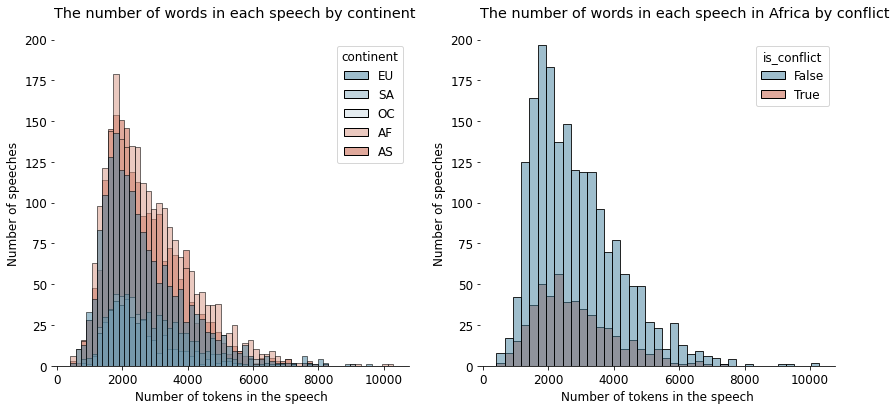

In [288]:
fig, axs = plt.subplots(1,2, figsize=(14,6))

sns.histplot(df, x='no_tokens', hue='continent', ax=axs[0], palette=palette)
sns.histplot(dfa, x='no_tokens', hue='is_conflict', palette=[colorcodes[x] for x in [-1,0]])

axs[0].set_title("The number of words in each speech by continent\n", loc='left')
axs[1].set_title("The number of words in each speech in Africa by conflict\n", loc='left')

locs=['top', 'right', 'left']
for ax in axs: 
    for loc in locs: ax.spines[loc].set_visible(False)
 
    ax.set_xlabel("Number of tokens in the speech")
    ax.set_ylabel("Number of speeches")
    
    ax.set_ylim((0,200))
    
fig.savefig('./Figures/2021-07-14 speech_length.pdf')

## Armed Conflict

In [182]:
dfa_conflict = dfa[dfa.is_conflict == 1]

In [272]:
is_conflict = pd.DataFrame(dfa.is_conflict.value_counts()).reset_index()

In [273]:
is_conflict

,index,is_conflict
0,False,1912
1,True,514


In [277]:
palette = sns.diverging_palette(230,20)


In [280]:
colorcodes_2 = [colorcodes[x] for x in [-1, 0]]

Text(0, 0.5, 'Number of conflicts')

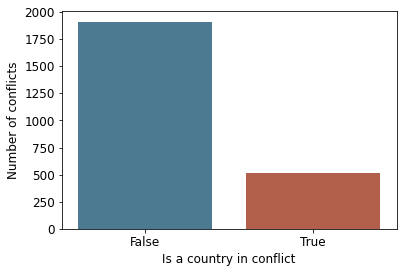

In [285]:
fig, ax = plt.subplots(1,1)
sns.barplot(x='index', y='is_conflict', data=is_conflict, palette=colorcodes_2, ax=ax)

ax.set_ylabel("Number of conflicts")

In [256]:
dfa.is_conflict.value_counts()

False    1912
True      514
Name: is_conflict, dtype: int64

In [185]:
dfa_conflict.incompatibility.value_counts()

Government                  336
Territory                   118
G&T (multiple conflicts)     60
Name: incompatibility, dtype: int64

In [189]:
dfa_conflict['type_of_conflict'].value_counts()

Intrastate                      354
Internationalized intrastate    120
Multiple conflicts               25
Interstate                       15
Name: type_of_conflict, dtype: int64

In [550]:
dfa_conflict[dfa_conflict.type_of_conflict == 'Interstate']

,year,country,text,session,country_map,is_conflict,n_conflicts,total_deaths,incompatibility,intensity,type_of_conflict,conflict_before,no_tokens,countryname,continent
409,1987,LBY,﻿\n\nI should first like to extend to you. Sir...,42,LBY,True,1,0.0,Territory,War,Interstate,Conflict before,3200,Libya,AF
698,1977,SOM,﻿132.\tAt the outset of my statement I should ...,32,SOM,True,1,0.0,Territory,War,Interstate,Conflict before,4155,Somalia,AF
699,1978,SOM,"﻿90.\tMr. President, on behalf of my delegatio...",33,SOM,True,1,0.0,Territory,War,Interstate,Conflict before,4451,Somalia,AF
701,1980,SOM,"﻿126.\tI am happy to extend to you. Sir, on be...",35,SOM,True,1,0.0,Territory,Conflict,Interstate,Conflict before,3472,Somalia,AF
1024,1985,BFA,As we begin our work the Government and friend...,40,BFA,True,1,0.0,Territory,Conflict,Interstate,Conflict after,1646,Burkina Faso,AF
1196,1973,EGY,﻿78.\tBecause we are determined not to neglect...,28,EGY,True,1,0.0,Territory,War,Interstate,Conflict before,408,Egypt,AF
1354,1985,MLI,Forty years ago the world had hardly emerged f...,40,MLI,True,1,0.0,Territory,Conflict,Interstate,Conflict after,3940,Mali,AF
1548,1983,NGA,"﻿232.\t Mr. President, I should like, first of...",38,NGA,True,1,0.0,Territory,Conflict,Interstate,Conflict before,4649,Nigeria,AF
1561,1996,NGA,"﻿On behalf of the Nigerian\ndelegation, I conv...",51,NGA,True,1,56.0,Territory,Conflict,Interstate,Conflict before,3414,Nigeria,AF
1691,1978,TZA,"﻿\n\n1. Mr. President,\non behalf of the Tanza...",33,TZA,True,1,0.0,Territory,Conflict,Interstate,Conflict after,2969,Tanzania,AF


In [192]:
dfa_conflict['n_conflicts'].value_counts()

1    431
2     62
3     13
4      3
6      3
5      2
Name: n_conflicts, dtype: int64

In [241]:
year_max_c = dfa_conflict[dfa_conflict.total_deaths==0].year.max()
print(f"Conflict deaths are available only from years after {year_max_c}")

dfa_conflict_v2 = dfa[dfa.year > year_max_c]

Conflict deaths are available only from years after 1988


In [ ]:
sns.boxplot(x='value', y='variable', data=df2, width=0.7, ax=ax, orient='h', 
            order=order, palette=colorcodes, boxprops=dict(alpha=.8),
            saturation=.9)

In [303]:
vars_plot = dfa_conflict_v2[['total_deaths', 'year', 'countryname', 'type_of_conflict']].copy()

In [358]:
vars_plot_agg = pd.DataFrame(vars_plot.groupby('countryname').total_deaths.mean().sort_values()).reset_index().reset_index()
vars_plot_agg['index'] += 1
vars_plot_agg = vars_plot_agg.rename(columns={'index': 'importance'})

In [359]:
my_range=range(1,len(vars_plot_agg)+1)


In [382]:
vars_plot_agg['total_deaths_log'] = vars_plot_agg['total_deaths'].map(lambda x: 0 if x == 0 else np.log10(x))

In [399]:
sort_vals = vars_plot_agg['countryname'].values

In [431]:
vars_plot['total_deaths_log'] = vars_plot['total_deaths'].map(lambda x: 0 if x == 0 else np.log10(x))

In [432]:
deaths = {}

for c in sort_vals:
    deaths[c] = np.array(vars_plot.loc[vars_plot.countryname == c, 'total_deaths_log'])

In [456]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

In [544]:
avg_marker = mlines.Line2D([], [], color=colorcodes[0], marker='|', linestyle='None',
                          markersize=15, label='Average number of deaths')

death_marker = mlines.Line2D([], [], color='grey', marker='o', linestyle='None',
                          markersize=6, alpha=0.5, label='Deaths in a given year')

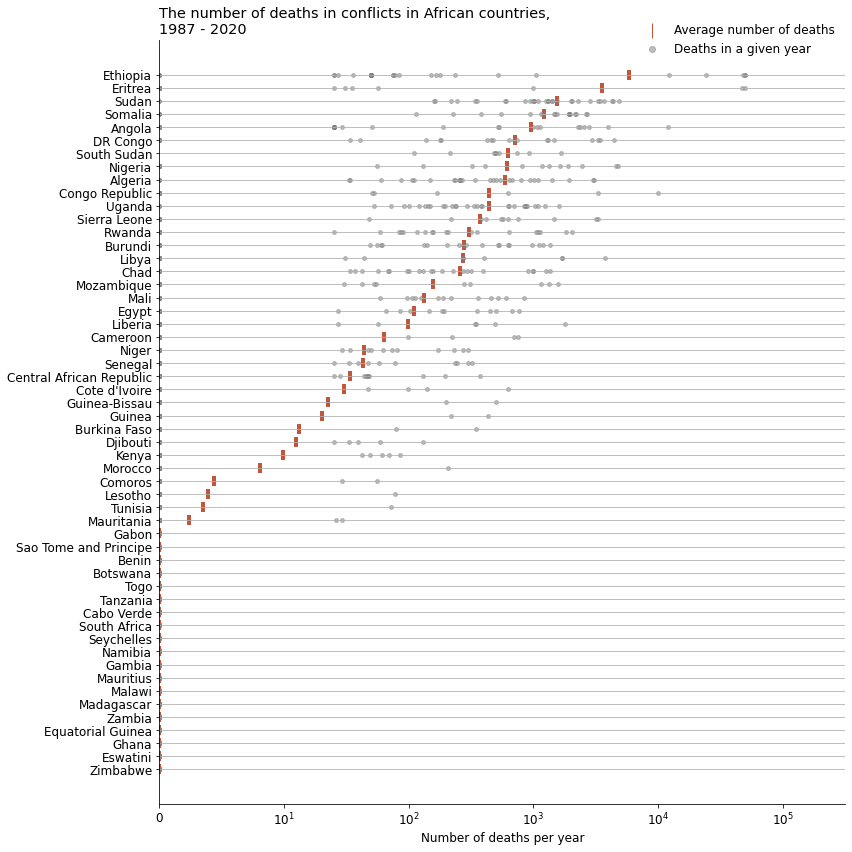

In [549]:
fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.scatter(vars_plot_agg.total_deaths_log, my_range, marker='|', s=100, linewidth=4, color=colorcodes[0])
    
# Get the dots for each country
for i, c in zip(my_range, deaths.items()):
    country, arr = c
    
    for item in arr:
        ax.scatter(item, i, color='grey', s=15, alpha=0.5)
        
    
# Update y-axis
ax.set_yticks(vars_plot_agg['importance'])
ax.set_yticklabels(list(vars_plot_agg.countryname))

# Update x-axis
number_ls = [0,1,2,3,4,5]
updated_xaxis = [0] + [f"$10^{x}$" for x in number_ls[1:]]
ax.set_xticks(number_ls)
ax.set_xticklabels(updated_xaxis)
ax.set_xlabel("Number of deaths per year")

ax.set_xlim((0,5.5))

locs=['top', 'right']
for loc in locs: ax.spines[loc].set_visible(False)
    
# Set y axis gridlines
ax.yaxis.grid(True)

# Set title
ax.set_title("The number of deaths in conflicts in African countries, \n1987 - 2020", loc='left')
    
# Set legend
ax.legend(handles=[avg_marker, death_marker], frameon=False, loc='right', bbox_to_anchor=(1, 1))

plt.tight_layout()
fig.savefig('./Figures/2021-07-14 number_of_conflicts.pdf')

In [243]:
vars_plot['total_deaths_v2'] = vars_plot['total_deaths'] + 0.1

In [244]:
palette=colorcodes,

In [245]:
palette = dict(zip(np.unique(vars_plot.country), sns.diverging_palette(230,20)))

In [ ]:
# Highlight different conflict types in the visual (!!)

## K-means dataset visualization

K=28 is the final choice

In [90]:
import json

In [95]:
file_path = "./Datasets/2021-07-13 results_sentence_clustering.json"

In [96]:
with open(file_path) as f:
    kmeans = json.loads(f.read())

In [97]:
kmeans_df = pd.DataFrame(kmeans).transpose()
cols = kmeans_df.columns[1:]

K = 28 <-- final K

In [123]:
ssc = kmeans_df['m_silhouette']

In [146]:
x = list([int(k) for k in ssc.index][:-1])
y = list(ssc.values[:-1])

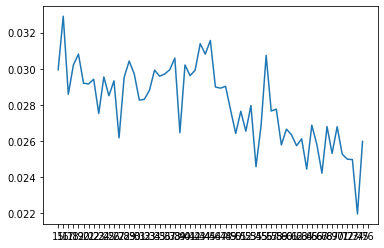

In [152]:
plt.plot(ssc)

In [168]:
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']

In [207]:
cluster=28
index_cluster = [np.array(x)==cluster][0]

In [298]:
import matplotlib.patches as mpatches
from matplotlib.patches import Line2D

ImportError: cannot import name 'Line2D' from 'matplotlib.patches' (C:\Users\Paulius\anaconda3\lib\site-packages\matplotlib\patches.py)

In [295]:
# Create a legend
normal_patch = mpatches.Patch(color='#D79787', label='Number of posts')
custom_line = Line2D([0], [0], color='black', marker='o', lw=1, label = 'Mean Gini Coefficient')

NameError: name 'Line2D' is not defined

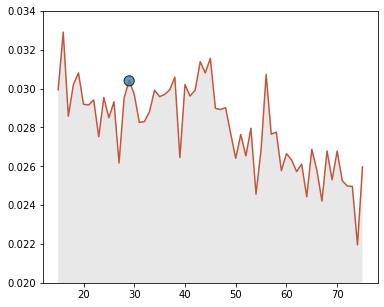

In [292]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.plot(x, y, color=colorcodes[0])
ax.fill_between(x,y,0, facecolor='#d3d3d3', alpha=0.5)
ax.set_ylim((0.020, 0.034))

# Add circle
xcircle = 29

pad=0.3
ax.annotate(" ", xy=(xcircle,0.0303),  fontsize=7, color='white', ha='center',
            bbox={'boxstyle': 'circle', 'pad': pad, 'facecolor': colorcodes[-1], 'edgecolor': 'black', 'alpha':0.8});

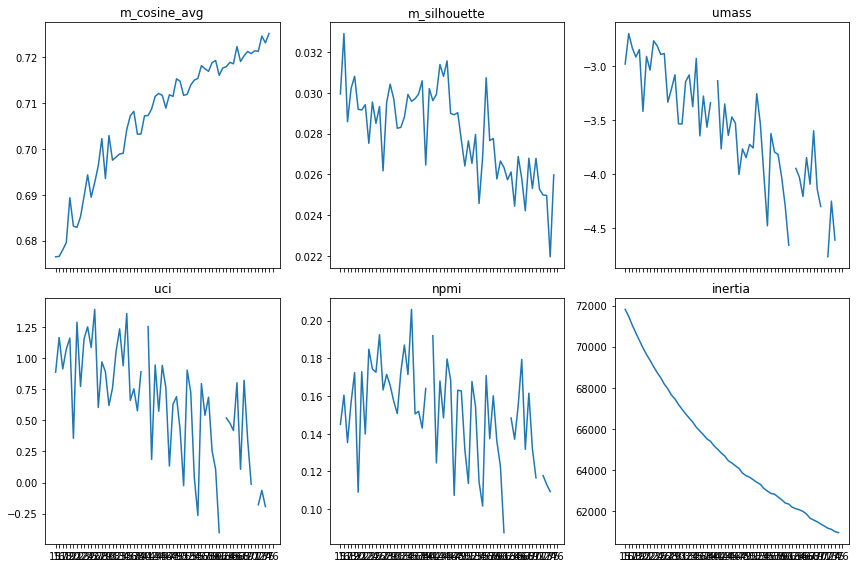

In [256]:
fig, axs = plt.subplots(2,3, figsize=(12,8), sharex=True)

axs = axs.flatten()
for k, ax in zip(cols, axs):
    ax.plot(kmeans_df[k])
    ax.set_title(kmeans_df[k].name)
    
plt.tight_layout()

# Archive: Getting embeddings

In [3]:
# Load data
df = pd.read_csv('./Datasets/2021-06-11 main_df.csv')


## EDA on embeddings

Reading the data

In [7]:
df = pd.read_csv('./Datasets/2021-06-11 main_df.csv')

In [8]:
# Drop useless columns (bad formatting)
dropcols = ['word_weight', 'weights', 'weights_avg', 'embedding_1']
df = df.drop(dropcols, axis=1)

In [9]:
# Convert the columns into lists
usecols = ['clean_text', 'sentences']
for col in usecols: df[col] = df[col].map(lambda x: ast.literal_eval(x))

In [159]:
#df['word_weight'] = df['word_weight'].map(dict)

In [165]:
# Export the word weights to somewhere
with open('./Datasets/2021-06-20 tfidf.json', 'wb') as f:
    pickle.dump(list(df['word_weight']), f)

In [29]:
# Export the word weights to somewhere
with open('./Datasets/2021-06-20 tfidf.json', 'rb') as f:
    word_weights = f.read()

In [33]:
word_weights

In [176]:
word_vectors = pd.read_pickle('./Datasets/2021-06-20 myvectors.pickle')

In [250]:
def get_vector(text, word_vectors=word_vectors):
    """Gets vector from some text"""
    return np.array([word_vectors.get(w) for w in text])

In [ ]:
df['sentences'] = df.sentences.map(ast.literal_eval)
df['sentences_lowercase'] = df.sentences.progress_apply(clean_ls)

In [225]:
words = list(word_vectors.keys())

In [230]:
all_w = set(df.sentences_lowercase.explode().explode())

In [233]:
nowords = []
for w in all_w:    
    try:
        word_vectors[w]
    except:
        nowords.append(w)

In [235]:
all_w_counts = df.sentences_lowercase.explode().explode().value_counts()

In [251]:
df['embeddings_1'] = df.sentences_lowercase.map(lambda ls: [get_vector(sent) for sent in ls])

<ipython-input-250-8aa5a7e9805a>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([word_vectors.get(w) for w in text])


## T-SNE

In [102]:
# Fit T-SNE model
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1000, random_state=0)
tsne_results = tsne.fit_transform(list(df.embedding_1))

In [121]:
colorcodes = ['#C3553A', '#D79787', '#B6CBD6', '#407E9C']

In [123]:
def plot_var(col):
    unique_vals = df[col].unique()
    
    fig, ax = plt.subplots(1, figsize=(12, 6))
    for c in unique_vals:

        # Get unique value filter
        f_ = df[col] == c

        # Get unique values
        ax.scatter(tsne_results[f_, 0], tsne_results[f_, 1],
                   alpha=0.2,
                   label=c)

    ax.legend()

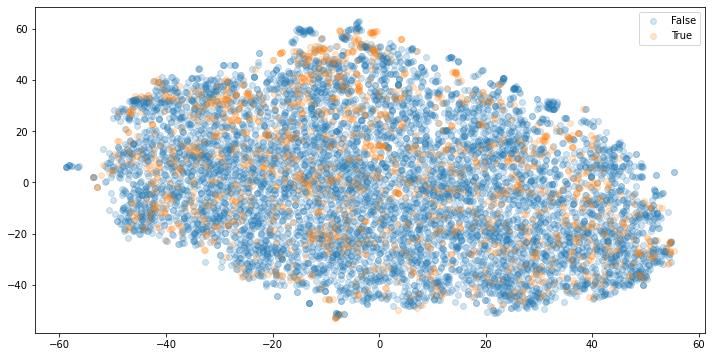

In [124]:
plot_var('is_war')

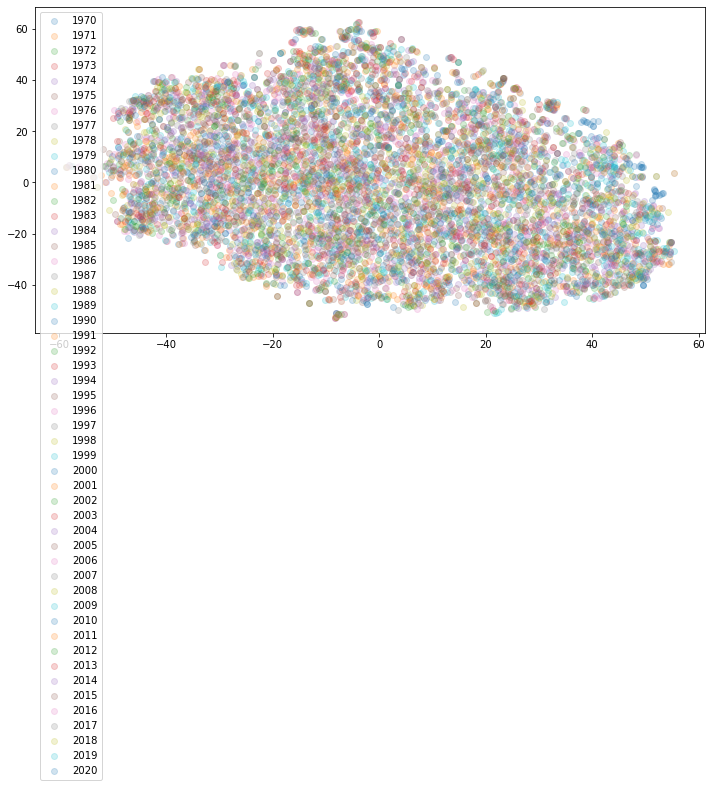

In [127]:
plot_var('year')

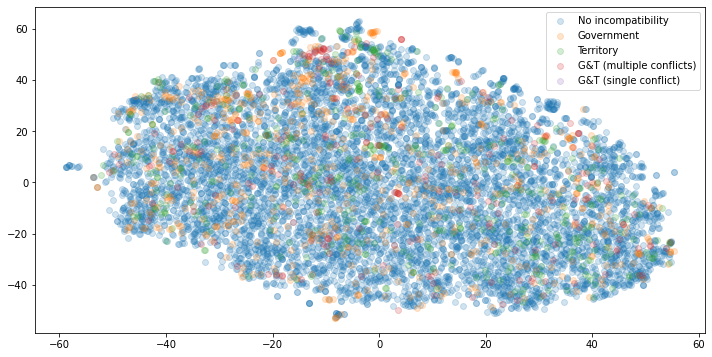

In [129]:
plot_var('incompatibility')

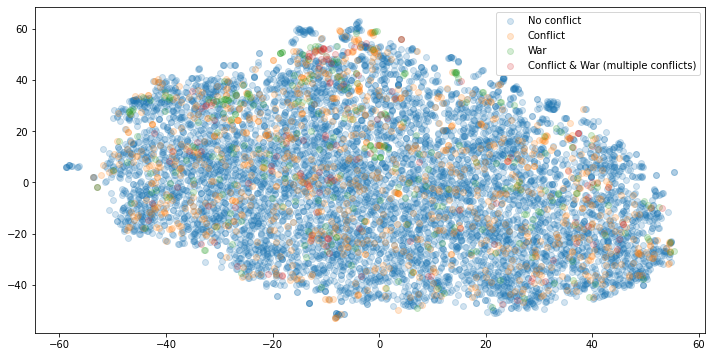

In [130]:
plot_var('intensity')

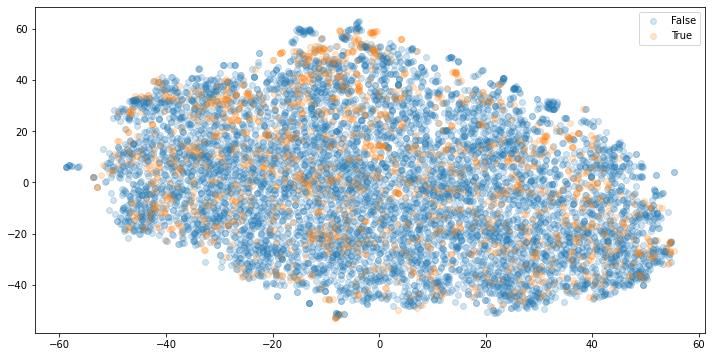

In [122]:
fig, ax = plt.subplots(1, figsize=(12, 6))
for c in unique_vals:
    
    # Get unique value filter
    f_ = df[col] == c
    
    # Get unique values
    ax.scatter(tsne_results[f_, 0], tsne_results[f_, 1],
               alpha=0.2,
               label=c)
    
ax.legend()

In [140]:
df['sentences'] = df.sentences.map(ast.literal_eval)

In [141]:
s1 = df['sentences'].iloc[0]

In [167]:
df['weights'].iloc[0]

'[11.75942618  4.01397724  9.71323352 ... 18.06734563 16.51236161\n 18.28388143]'

In [168]:
df.weights.head()

0    [11.75942618  4.01397724  9.71323352 ... 18.06...
1    [19.58556546 10.65949855 18.11108021 ... 19.51...
2    [13.63424696 13.09156634  6.3620034  ... 19.28...
3    [ 5.01249876  4.84891161 18.52958537 ... 11.55...
4    [ 0.          4.84891161  0.         ... 16.80...
Name: weights, dtype: object

### Text2sent archive

In [162]:
def text2sent(t):
    """This is an archival version, I am now using tokenizer from NLTK"""
    
    # Lowercase everything
    t = ' '.join([w.lower() for w in t.split()])
    
    # Replace words
    abbreviations = ['mr.', 'mrs.', 'prof.', 'no.', 'anon.', 'apt.', 'approx.', 'cont.',
                    'esp.', 'et al.', 'fig.', 'etc.', 'max.', 'min.', 'misc.',
                    'qty.', 'vs.']
    
    # Lowercase abbreviations only if there is a space before the word. Also, removing the comma
    abbreviations = [' ' + x[:-1] + '\.' for x in abbreviations]

    # Remove dots from all the aforementioned abbreviations
    for abbr in abbreviations:
        t = re.sub(abbr, abbr[:-2], t)
        
    # Further remove dots from these common abbreviations with two words.
    t2 = re.sub('e\.g\.', 'eg', t)
    t2 = re.sub('i\.e\.', 'ie', t2)
    t2 = re.sub('n\.b\.', 'nb', t2)
    t2 = re.sub('p\.a\.', 'pa', t2)
    t2 = re.sub('p\.s\.', 'ps', t2)


    t2 = re.sub("[^a-zA-Z'\.\?\!]", " ", t2.replace('\t', '.').replace('\n', '.')).strip()
    t2 = re.sub('\.\.+', '.', t2)
    
    # Replace several spaces
    t2 = re.sub(' +',' ', t2)
    
    # Remove sentences that are one word. 
    tx = [clean(re.sub(' +', ' ', x.strip())) for x in re.split('[\.\?\!]', t2) if len(x.strip()) > 1]
    
    return tx

## Mutual information: getting conditional probabilities

In [ ]:
# Store the data in a dictionary for total posts
n_posts_total = {}
for c1 in labels_all:
    n_posts_total[c1] = len(sentences_by_topic[c1])

# Get total posts
#n_posts_sum = {}
#for c1 in labels_all:
#    n_posts_sum[c1] = np.su
    
# Loop over categories and MI scores and calculate the top words
inf_words = {}
n = 100 # top words
for c1 in tqdm(labels_all):
    inf_words[c1] = []
    
    for v, w in mi_score[c1][::-1][:n]:
    
        # Get the conditional probabilities of the word for the base category
        count_c1 = len(sentences_by_topic[c1])
        cond1 = n_posts[c1][w] / count_c1

        # Get the conditional probability of the word for the rest of the categories
        count_c2 = np.sum([n_posts_total[c] for c in labels_all if c != c1])
        n_posts_sum = np.sum([n_posts[c][w] for c in labels_all if c != c1])
        cond2 = n_posts_sum / count_c2

        if cond1 > cond2: inf_words[c1].append(w)